# Case Numera People Analytics - Target Marketing para Gelateria Lillo

#### Ana Carolina Novaes Silva

#### 30 de setembro

### Introdução

A gelateria Lillo é muito famosa na capital mineira e vende gelatos de altíssima qualidade com foco no público de classe B+.
Quando um cliente compra algum produto, é incentivado que ele preencha seu cpf, email e telefone para receber promoções e novidades. Com esses dados, a gelateria possui uma base de clientes robusta.

A gerente da gelateria pediu a nossa ajuda para melhorar as campanhas de marketing e aumentar a receita. Para isso, ela disponibilizou 3 bases com as seguintes informações:

##### Portfolio_ofertas: contém as ofertas que são enviadas e possui as seguintes colunas:
· ID: código de identificação da oferta

· Oferta: Tipo de oferta enviada, podendo ser informativo, desconto e compre 1 e leve 2.

· Canal: canal de envio da comunicação podendo ser email, web, celular e redes sociais.

· Valor mínimo: valor mínimo necessário a ser gasto para aproveitar a oferta

· Recompensa: pontuação obtida por completar a compra da oferta

· Duração: tempo de duração da oferta em dias.

##### Dados_clientes: dados demográficos dos clientes e possui as seguintes colunas:
· Gênero: gênero do cliente

· Idade: idade dos clientes

· Id: código único de cada cliente

· Membro_desde: data em que o cliente criou uma conta

· Renda_anual: renda anual fornecida pelo cliente.

##### Eventos_ofertas: base com registros de todos os eventos
· Tipo_evento: descrição dos ofentos ocorridos, podendo ser: transação, oferta recebida, oferta vista, oferta finalizada.

· Cliente: código do cliente que executou aquele evento

· Tempo_decorrido: tempo em horas desde o envio da oferta

· Valor: contém informação do valor gasto na compra

· id_oferta: código da oferta


##### Como analistas de dados, a nossa missão aqui é ajudar a gelateria Lillo a otimizar as campanhas de marketing.

#### Entregáveis:

- Recomendação de segmentação de clientes e sugestão de estratégia de venda/promoção adequada para cada segmento identificado. (Nosso interesse é em entender como a segmentação foi gerada e quais são as características de cada segmento que sustentam a sugestão de estratégia)

- Script de análise dos dados

#### Objetivos:

- Vamos olhar para as características demográficas e comportamentais dos clientes para prever qual seria a melhor oferta para enviar a cada cliente especificamente que maximizaria a taxa de conversão de oferta em compra.


- Vamos obter diferentes subgrupos de clientes que mostram certos padrões demográficos e comportamentos de compra, que os diferenciam uns dos outros.

O grande detalhe é que cada oferta tem um período de validade, então um cliente pode receber uma oferta do tipo 'compre 1, leve 2', mas nunca abrir a oferta durante o período de validade e comprar algo sem oferta durante esse período. Haverá um registro de oferta concluída, mas o cliente não foi influenciado pela oferta porque o cliente nunca viu a oferta. Para as ofertas informativas, se um usuário fizer transações dentro do período de validade após a visualização da oferta, será uma oferta concluída.

A parte principal é resumir os comportamentos de transação de cada cliente de acordo com o tempo em que as ações são realizadas para atribuir as transações certas aos tipos de ofertas certos e rastrear as conversões para diferentes ofertas de cada cliente. 

Essas informações serão combinadas com as informações dos clientes, como renda, idade, sexo e quando sua filiação começou.

A abordagem para resolver o problema seguirá as seguintes etapas:

##### 1. Análise Exploratória dos Dados (EDA)
##### 2. Engenharia dos recursos
##### 3. Machine Learning
##### 4. Clusterização/Segmentação

In [138]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Lendo os arquivos csv
dados_clientes = pd.read_csv('dados_clientes.csv')
portfolio_ofertas = pd.read_csv('portfolio_ofertas.csv')
eventos_ofertas = pd.read_csv('eventos_ofertas.csv')

 ### 1. Análise exploratória dos dados (EDA)
         1.1. dados_clientes
         1.2. portfolio_ofertas
         1.3. eventos_ofertas

In [139]:
# 1.1. dados_clientes

# para visualizar a base em um dataframe
dados_clientes = pd.DataFrame(dados_clientes)
dados_clientes.head()

,Unnamed: 0,genero,idade,id,membro_desde,renda_anual
0,1,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,3,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,4,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,5,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [140]:
# número de observações
dados_clientes.shape

(17000, 6)

In [141]:
# Quantos clientes não têm algum tipo de informação?
dados_clientes.isnull().sum() 

#2175 de 17000 clientes não têm informações de gênero e renda anual

Unnamed: 0         0
genero          2175
idade              0
id                 0
membro_desde       0
renda_anual     2175
dtype: int64

Text(0, 0.5, 'Frequência')

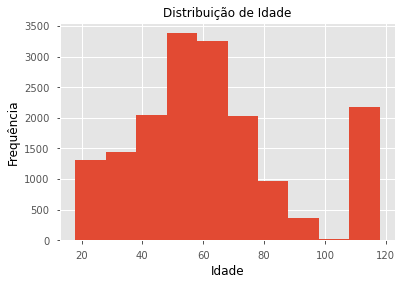

In [142]:
# para visualizar a distribuição de idade dos clientes 
dados_clientes.idade.plot.hist()
plt.title('Distribuição de Idade', fontsize = 12)
plt.xlabel(('Idade'), color = 'black')
plt.ylabel(('Frequência'), color = 'black')

Existem muitas pessoas com mais de 100 anos, o que não faz muito sentido. São "outliers". Outliers são dados que se diferenciam drasticamente de todos os outros.

In [143]:
# para verificar outliers 
dados_clientes.idade[dados_clientes.idade>=100].value_counts() 

118    2175
100      12
101       5
Name: idade, dtype: int64

Existem outliers de idade. Não faz sentido +2000 pessoas terem 118 anos.

Talvez todos os clientes que não têm informações de gênero e renda anual sejam exatamente os que possuem essa idade. Se isso for verdade, poderíamos começar a pensar simplesmente em excluir os outliers da base, mas existem outras informações importantes que esses clientes fornecem e que são necessárias para a análise (como data de posse de fidelização como membro, por exemplo, e outras que irão surgir). 

Para não perder essas informações, ao invés de excluir os outliers, vamos transformar esse valor de 118 em nulo e depois trocá-lo pela idade média dos clientes. Assim, nossa base não sairá afetada.

Vamos lá, então!

In [144]:
# Transformando a idade de 118 em NA
dados_clientes.idade[dados_clientes.idade>=100] = np.nan

# Transformando os NA na idade média de clientes
idade_media = dados_clientes.idade.median()
dados_clientes.idade = dados_clientes.idade.fillna(idade_media)

Agora, vamos visualizar de novo a distribuição de idade dos clientes para verificar se ficou do jeito que a gente queria:

Text(0, 0.5, 'Frequência')

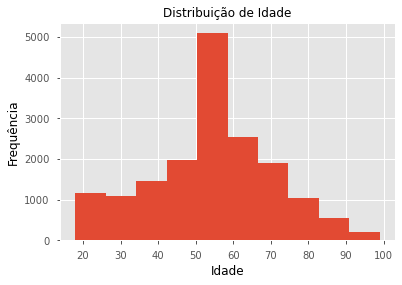

In [145]:
dados_clientes.idade.plot.hist()
plt.title('Distribuição de Idade', fontsize = 12)
plt.xlabel(('Idade'), color = 'black')
plt.ylabel(('Frequência'), color = 'black')

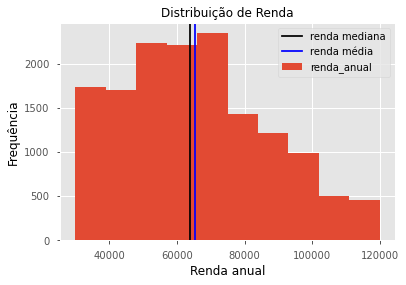

In [146]:
# visualizando a distribuição da renda anual
dados_clientes.renda_anual.plot.hist()
plt.axvline(dados_clientes['renda_anual'].median(), color = 'black', linestyle = '-', label = 'renda mediana')
plt.axvline(dados_clientes['renda_anual'].mean(), color = 'blue', linestyle = '-', label = 'renda média')
plt.title('Distribuição de Renda', fontsize = 12)
plt.xlabel(('Renda anual'), color = 'black')
plt.ylabel(('Frequência'), color = 'black')
plt.legend()

Text(0, 0.5, 'Frequência')

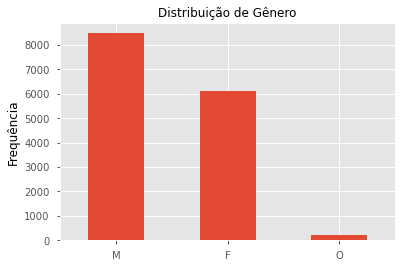

In [147]:
# visualizando a distribuição de gênero
dados_clientes.genero.value_counts().plot.bar(rot=0)
plt.title('Distribuição de Gênero', fontsize = 12)
plt.ylabel(('Frequência'), color = 'black')

No plot acima percebemos que há mais clientes do sexo masculino do que feminino.

In [148]:
# Quando os clientes se filiaram à sorveteria
dados_clientes.membro_desde = pd.to_datetime(dados_clientes['membro_desde'], format='%Y%m%d')
dados_clientes['membro_desde_ano'] = dados_clientes['membro_desde'].dt.year #ano de filiação

Text(0, 0.5, 'Quantidade de filiações')

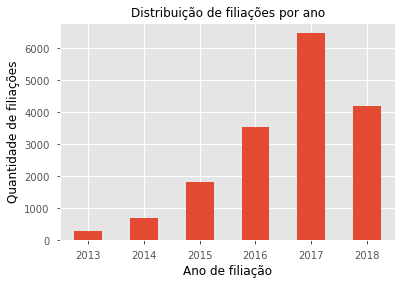

In [149]:
# Visualizando as posses como membro filiado por ano
dados_clientes['membro_desde_ano'].value_counts().sort_index().plot.bar(rot=0)
plt.title('Distribuição de filiações por ano', fontsize = 12)
plt.xlabel(('Ano de filiação'), color = 'black')
plt.ylabel(('Quantidade de filiações'), color = 'black')

2017 é o ano em que mais clientes se filiaram

Text(0, 0.5, 'Quantidade de filiações')

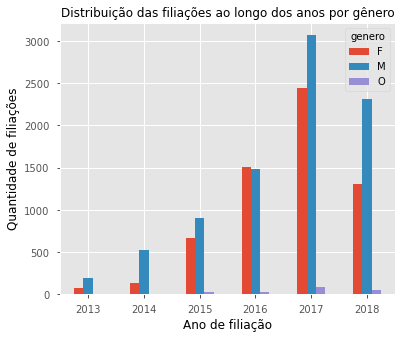

In [150]:
# Vamos agrupar as filiações de cada ano por gênero
dados_clientes.groupby('membro_desde_ano')['genero'].value_counts().unstack().sort_index().plot.bar(figsize=(6,5), rot=0)
plt.title('Distribuição das filiações ao longo dos anos por gênero', fontsize = 12)
plt.xlabel(('Ano de filiação'), color = 'black')
plt.ylabel(('Quantidade de filiações'), color = 'black')

O gráfico acima mostra que os clientes do sexo masculino têm crescido muito mais do que o feminino na maioria dos anos.

Agora, vamos agrupar as filiações por mês de filiação. Isso vai ser importante pra analisar a linha cronológica de filiação. Vamos lá! Em 6 anos de dados, temos 72 meses. Uma vez que temos a informação do mês de filiação, podemos visualizar quantas
filiações foram feitas ao longo dos meses:

In [151]:
# determinando e visualizando quantas filiações foram feitas ao longo dos meses
dados_clientes['posse_membro'] = round(((pd.to_datetime('20181231', format='%Y%m%d')) - dados_clientes['membro_desde'])/np.timedelta64(1, 'M')) #filiações por mês

Text(0, 0.5, 'Quantidade de filiações')

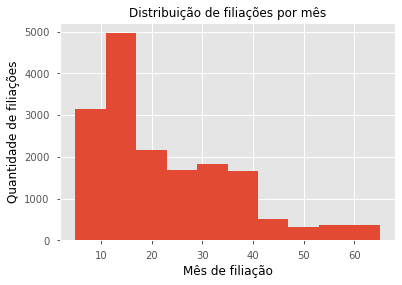

In [152]:
dados_clientes['posse_membro'].plot.hist(rot=0)
plt.title('Distribuição de filiações por mês', fontsize = 12)
plt.xlabel(('Mês de filiação'), color = 'black')
plt.ylabel(('Quantidade de filiações'), color = 'black')


In [153]:
# 1.2. portfolio_ofertas

# visualizar os dados em dataframe
portfolio_ofertas = pd.DataFrame(portfolio_ofertas)
portfolio_ofertas.head(20)

,Unnamed: 0,recompensa,canal,valor_minimo,duracao,id,oferta
0,1,10,"['email', 'mobile', 'social']",10,7,ae264e3637204a6fb9bb56bc8210ddfd,"compre 1, leve 2"
1,2,10,"['web', 'email', 'mobile', 'social']",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,"compre 1, leve 2"
2,3,0,"['web', 'email', 'mobile']",0,4,3f207df678b143eea3cee63160fa8bed,informativo
3,4,5,"['web', 'email', 'mobile']",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,"compre 1, leve 2"
4,5,5,"['web', 'email']",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,desconto
5,6,3,"['web', 'email', 'mobile', 'social']",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,desconto
6,7,2,"['web', 'email', 'mobile', 'social']",10,10,fafdcd668e3743c1bb461111dcafc2a4,desconto
7,8,0,"['email', 'mobile', 'social']",0,3,5a8bc65990b245e5a138643cd4eb9837,informativo
8,9,5,"['web', 'email', 'mobile', 'social']",5,5,f19421c1d4aa40978ebb69ca19b0e20d,"compre 1, leve 2"
9,10,2,"['web', 'email', 'mobile']",10,7,2906b810c7d4411798c6938adc9daaa5,desconto


quando se trata de "recompensa", a coluna do evento vai mostrar "oferta concluída", caso contrário, o evento é "oferta recebida" ou "oferta visualizada". Quando "valor" não é nulo, o evento é sempre uma "transação".

In [154]:
print(type(portfolio_ofertas.canal)) # não está no formato de lista. 

<class 'pandas.core.series.Series'>


Vamos verificar quantas ofertas existem por tipo de oferta. Isso é necessário porque existem algumas diferenças entre elas, como o valor da recompensa e o tempo de duração da oferta

In [155]:
portfolio_ofertas.oferta.value_counts()

desconto            4
compre 1, leve 2    4
informativo         2
Name: oferta, dtype: int64

Agora, vamos criar novas colunas para ser possível analisar por quais canais as ofertas são distribuídas para os clientes

In [156]:
# criando colunas dummy para os diferentes tipos de canais de marketing
portfolio_ofertas['web'] = portfolio_ofertas['canal'].apply(lambda x: int('web' in x) if isinstance(x, str) else 0)
portfolio_ofertas['email'] = portfolio_ofertas['canal'].apply(lambda x: int('email' in x) if isinstance(x, str) else 0)
portfolio_ofertas['mobile'] = portfolio_ofertas['canal'].apply(lambda x: int('mobile' in x) if isinstance(x, str) else 0)
portfolio_ofertas['social'] = portfolio_ofertas['canal'].apply(lambda x: int('social' in x) if isinstance(x, str) else 0)

In [157]:
# visualizando os dados em dataframe
portfolio_ofertas.head()

,Unnamed: 0,recompensa,canal,valor_minimo,duracao,id,oferta,web,email,mobile,social
0,1,10,"['email', 'mobile', 'social']",10,7,ae264e3637204a6fb9bb56bc8210ddfd,"compre 1, leve 2",0,1,1,1
1,2,10,"['web', 'email', 'mobile', 'social']",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,"compre 1, leve 2",1,1,1,1
2,3,0,"['web', 'email', 'mobile']",0,4,3f207df678b143eea3cee63160fa8bed,informativo,1,1,1,0
3,4,5,"['web', 'email', 'mobile']",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,"compre 1, leve 2",1,1,1,0
4,5,5,"['web', 'email']",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,desconto,1,1,0,0


<AxesSubplot:xlabel='oferta'>

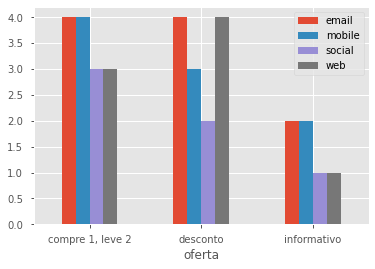

In [158]:
# visualizando a distribuição dos canais de marketing por tipo de oferta
portfolio_ofertas.groupby('oferta')['email','mobile','social','web'].sum().plot.bar(rot= 0 )

1. Podemos ver que ofertas do tipo compre 1, leve 2 (vamos chamar de culd) são enviadas majoritariamente por email e mobile;

2. ofertas do tipo desconto são enviadas majoritariamente por email e pela web;

3. ofertas do tipo informativo são enviadas majoritariamente por email e mobile.

In [159]:
# C. eventos_ofertas

# visualizando os dados em dataframe
eventos_ofertas = pd.DataFrame(eventos_ofertas)
eventos_ofertas.head()

,Unnamed: 0,cliente,tempo_decorrido,valor,id_oferta,recompensa,tipo_evento
0,1,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,oferta recebida
1,2,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,oferta recebida
2,3,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,oferta recebida
3,4,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,oferta recebida
4,5,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,oferta recebida


In [160]:
# número de observações
eventos_ofertas.shape

(306534, 7)

In [161]:
# Quantos são os clientes (sem repetir) na base de eventos?
eventos_ofertas.cliente.unique().shape[0]

17000

São 17 mil clientes ao todo, o que bate com a base de 'dados_clientes'.

In [162]:
# contar quantos eventos foram realizados por tipo de evento
eventos_ofertas.tipo_evento.value_counts()

transacao             138953
oferta recebida        76277
oferta visualizada     57725
oferta conclu�da       33579
Name: tipo_evento, dtype: int64

 Podemos observar que os eventos ocorrem de 3 maneiras:
 
        1. o cliente recebe a oferta e a utiliza para compra;
        2. o cliente recebe a oferta, mas não a utiliza (e não compra);
        3. o cliente não recebe a oferta, mas compra do mesmo jeito.

In [163]:
# vamos visualizar a quantidade de eventos por maneira de ocorrência:
print('Eventos em que a oferta é recebida e usada')
print(eventos_ofertas.loc[(eventos_ofertas['id_oferta'].notnull()) & (eventos_ofertas['recompensa'].notnull()),'tipo_evento'].value_counts())
print('\n')

print('Eventos em que a oferta é recebida mas não é usada')
print(eventos_ofertas.loc[(eventos_ofertas['id_oferta'].notnull()) & (eventos_ofertas['recompensa'].isnull()),'tipo_evento'].value_counts())
print('\n')

print('Eventos em que o valor da transação ocorre')
print(eventos_ofertas.loc[(eventos_ofertas['valor'].notnull()) ,'tipo_evento'].value_counts())

Eventos em que a oferta é recebida e usada
oferta conclu�da    33579
Name: tipo_evento, dtype: int64


Eventos em que a oferta é recebida mas não é usada
oferta recebida       76277
oferta visualizada    57725
Name: tipo_evento, dtype: int64


Eventos em que o valor da transação ocorre
transacao    138953
Name: tipo_evento, dtype: int64


In [164]:
# Renomeando a variável id para id_oferta. Vamos fazer isso pra não confundir depois com id do cliente
portfolio_ofertas.rename(columns={'id':'id_oferta'},inplace=True)

In [165]:
eventos_ofertas.head()

,Unnamed: 0,cliente,tempo_decorrido,valor,id_oferta,recompensa,tipo_evento
0,1,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,oferta recebida
1,2,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,oferta recebida
2,3,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,oferta recebida
3,4,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,oferta recebida
4,5,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,oferta recebida


Só agora podemos juntar a base "eventos_ofertas" à base "portfolio_ofertas". Vamos então juntá-las para identificarmos o tipo de oferta na primeira base.

In [166]:
# juntado as bases 'eventos_oferta' e 'portfolio_ofertas'
eventos_ofertas_novo = eventos_ofertas.merge(portfolio_ofertas,how='left',on='id_oferta')
eventos_ofertas_novo.groupby(['tipo_evento','oferta'])['oferta'].count()

tipo_evento         oferta          
oferta conclu�da    compre 1, leve 2    15669
                    desconto            17910
oferta recebida     compre 1, leve 2    30499
                    desconto            30543
                    informativo         15235
oferta visualizada  compre 1, leve 2    25449
                    desconto            21445
                    informativo         10831
Name: oferta, dtype: int64

In [167]:
#visualizando os dados em dataframe
eventos_ofertas_novo.head()

,Unnamed: 0_x,cliente,tempo_decorrido,valor,id_oferta,recompensa_x,tipo_evento,Unnamed: 0_y,recompensa_y,canal,valor_minimo,duracao,oferta,web,email,mobile,social
0,1,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,oferta recebida,4.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,"compre 1, leve 2",1.0,1.0,1.0,0.0
1,2,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,oferta recebida,5.0,5.0,"['web', 'email']",20.0,10.0,desconto,1.0,1.0,0.0,0.0
2,3,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,oferta recebida,10.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,desconto,1.0,1.0,1.0,0.0
3,4,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,oferta recebida,7.0,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,desconto,1.0,1.0,1.0,1.0
4,5,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,oferta recebida,2.0,10.0,"['web', 'email', 'mobile', 'social']",10.0,5.0,"compre 1, leve 2",1.0,1.0,1.0,1.0


In [168]:
# Renomeando as colunas de recompensa recebida (recompensa_x) e recompensa definida (recompensa_y)
eventos_ofertas_novo.rename(columns={'recompensa_x':'recompensa_recebida', 'recompensa_y':'recompensa_definida'},inplace=True) 

# Contando a quantidade de recompensas recebidas por valor de recompensa.
eventos_ofertas_novo.recompensa_recebida.value_counts()

5.0     12070
2.0      9334
10.0     7019
3.0      5156
Name: recompensa_recebida, dtype: int64

In [169]:
# Agora, vamos começar a traçar uma trajetória para cada cliente
eventos_ofertas_novo.loc[eventos_ofertas_novo['tipo_evento']=='oferta conclu�da', 'cliente'].head(3)

12658    9fa9ae8f57894cc9a3b8a9bbe0fc1b2f
12672    fe97aa22dd3e48c8b143116a8403dd52
12679    629fc02d56414d91bca360decdfa9288
Name: cliente, dtype: object

Vamos verificar a jornada de uma pessoa para ter uma ideia melhor da sequência de eventos quando ela conclui uma oferta.

In [170]:
# Vamos pegar um cliente como exemplo para analisar sua trajetória como cliente da sorveteria. (peguei o primeiro mesmo, mas pode ser qualquer um)
eventos_ofertas_novo.loc[eventos_ofertas_novo.cliente =='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f',:].sort_index().head(14)

,Unnamed: 0_x,cliente,tempo_decorrido,valor,id_oferta,recompensa_recebida,tipo_evento,Unnamed: 0_y,recompensa_definida,canal,valor_minimo,duracao,oferta,web,email,mobile,social
36,37,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,oferta recebida,10.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,desconto,1.0,1.0,1.0,0.0
12656,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,oferta visualizada,10.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,desconto,1.0,1.0,1.0,0.0
12657,12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12658,12659,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,oferta conclu�da,10.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,desconto,1.0,1.0,1.0,0.0
27850,27851,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,42,21.55,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44327,44328,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,114,32.87,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51350,51351,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,156,19.99,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65854,65855,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,168,20.97,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81403,81404,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,204,31.09,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110866,110867,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,oferta recebida,6.0,3.0,"['web', 'email', 'mobile', 'social']",7.0,7.0,desconto,1.0,1.0,1.0,1.0


Até aqui tudo ok! Agora é a hora de fazer perguntas! Vamos definir a questão central.

### O problema

Nós precisamos encontram um jeito de descobrir quais ofertas são eficazes pra cada cliente. Isso é possível porque temos a ordem cronológica dos eventos. Então, quando uma oferta é eficaz (ou seja, o cliente a usou para comprar alguma coisa), os eventos que levam o cliente a gastar (converter a oferta em compra) podem acontecer de duas maneiras:

1. oferta recebida -> oferta visualizada -> transação -> oferta concluída (aqui estaremos lidando com ofertas culd e de desconto);

2. oferta recebida -> oferta visualizada -> transação (aqui estermos lidando com ofertas do tipo informativo, dessa forma, as transações nesse caso devem ter acontecido dentro do período de duração da oferta)

Somente quando essas duas sequências de conversão são observadas, podemos contar a oferta como concluída.

Alguns outros cenários são considerados ofertas ineficazes:

1. quando a oferta é recebida, mas nenhuma ação é realizada pelos clientes (não é visualizada ou utilizada);

2. oferta recebida -> transação -> oferta visualizada (isso também é ineficaz porque o cliente não usou a oferta na transação, ele comprou antes de ver a oferta);

3. transação sem oferta (esse tipo de cliente faria transações de qualquer jeito com ou sem uma oferta. Por isso, não seria muito interessante do ponto de vista financeiro da empresa enviar ofertas para esse cliente).

#### O que queremos?

Já exploramos os dados. E agora? Qual é o nosso objetivo?

Queremos prever qual é o melhor tipo de oferta que devemos enviar para cada cliente individual e especificamente.

Por isso começamos a traçar a trajetória de cada cliente. Agora, vamos desenvolver um conjunto de dados no nível do cliente que inclua os dados demográficos, resumos dos comportamentos de transações de cada cliente e sua resposta a cada tipo de oferta.

Vamos criar algumas variáveis novas que irão nos auxiliar nessa questão. Vamos chamá-las de "recursos". Elas serão muito importantes para construir o modelo de aprendizado de máquina (machine learning) que nos trará o início da resposta para nossa pergunta princial. 

1. número de vezes que cada tipo de oferta é recebido (se o usuário executa ou não a oferta): oferta_culd_recebida, oferta_desconto_recebida, oferta_informativo_recebida

2. contagem total de transações (independentemente de a transação ser ou não incentivada pela oferta): total_qt_trans

3. valor total da transação (soma do valor total da transação): total_valor_trans

4. total de recompensas recebidas (soma das recompensas recebidas de qualquer tipo de oferta): total_recompensas_recebidas

5. valor médio da transação (total_valor_trans/total_qt_trans): valor_medio_transacao

6. tempos de transação sem qualquer oferta - quantas vezes o usuário transaciona sem um evento de conclusão de oferta: qt_trans_sem_oferta

7. quantidades de transações com conclusão de uma oferta - quantas vezes o usuário transaciona seguido por um evento de conclusão de oferta: qt_oferta_trans

8. valor da transação com qualquer oferta - valor total da transação com um evento de conclusão da oferta: valor_oferta_trans

9. taxa de contagem de transações incentivada pela oferta - tempos de transação com a conclusão de uma oferta / contagem total de transações: prop_qt_oferta_trans

10. proporção do valor da transação incentivada pela oferta - valor total da transação com um evento de conclusão da oferta / valor total da transação: prop_valor_oferta_trans

11. proporção de conclusão da oferta vs. oferta visualizada - número de ofertas concluídas / número de ofertas visualizadas: prop_visu_oferta_conc

12. conclusão da oferta vs. proporção de recebimento da oferta - número de ofertas concluídas / número de ofertas recebidas: prop_receb_oferta_conc

13. valor da transação por oferta - valor total da transação com oferta / contagem da transação com oferta: valor_trans_por_oferta

14. recompensas por oferta - recompensas totais recebidas / número de ofertas concluídas: recompensa_por_oferta

15. número de ofertas culd concluídas - número de eventos "oferta concluída" para o tipo de oferta culd após visualizar a oferta culd: culd_concl

16. número de ofertas de desconto concluídas - número de eventos de "oferta concluída" para o tipo de oferta de desconto após visualizar a oferta de desconto: desconto_concl

17. número de ofertas informativas concluídas - número de vezes que um evento de "transação" ocorre após visualizar a oferta informativa dentro da duração válida da oferta: informativo_concl

18. taxa de conversão da oferta culd - número de ofertas culd concluídas / número de ofertas culd recebidas: tx_conv_culd

19. taxa de conversão de oferta de desconto - número de ofertas de desconto concluídas / número de oferta de desconto recebida: tx_conv_desconto

20. taxa de conversão de oferta informativa - número de ofertas informativas concluídas / número de ofertas informativas recebidas: tx_conv_info

Há 3 variáveis de destino binárias para o modelo:

1. oferta_culd (0/1): se um usuário já teve um evento de "oferta concluída" para o tipo de oferta culd depois de visualizar a oferta, então 1, c.c. 0

2. oferta_desconto (0/1): se um usuário já teve um evento de "oferta concluída" para o tipo de oferta de desconto depois de visualizar a oferta, então 1, c.c. 0

3. oferta_informativo (0/1): se um usuário já teve um evento de "transação" seguido por "oferta visualizada" para o tipo de oferta informativa, então 1, c.c. 0

Ainda, temos o caso 'sem_oferta': se um usuário nunca respondeu a nenhuma oferta e apenas transaciona sem ofertas, então não temos nenhuma recomendação de oferta. Isso pode ser inferido quando há três 0 nos três tipos de oferta acima. Esta variável não será usada no modelo, mas pode ser usada como referência.

O maior desafio é identificar as ofertas eficazes corretas, seguindo a sequência específica de eventos que levam à conclusão da oferta, dependendo do tipo de oferta. Todos os recursos relacionados à oferta efetiva podem ser calculados com base na quantidade de ofertas concluídas e valor das transações das ofertas convertidas.

Essa é a etapa de engenharia dos recursos (ou das características).

Após essa etapa, vamos juntar os dados demográficos do cliente com os recursos em um dataframe final de características do cliente.

 ### 2. Engenharia de Recursos
 
         2.1. Número de vezes que cada tipo de oferta é recebida
         2.2. Quantidade total de transações
         2.3. Valor total de transações
         2.4. Total de recompensas recebidas
         2.5. Valor médio da transação
         2.6. Identificando as ofertas eficazes

In [171]:
# 2.1. número de vezes que cada tipo de oferta é recebida

# Criando um novo dataframe com a id do cliente como índice para vermos qual tipo de oferta o cliente recebeu
cliente_df = pd.DataFrame(index = dados_clientes.id)

In [172]:
# qual tipo de oferta o cliente recebeu
tipo_oferta_recebida = eventos_ofertas_novo.loc[eventos_ofertas_novo['tipo_evento']=='oferta recebida',:].groupby('cliente').oferta.value_counts().unstack()

# juntando as bases
cliente_df = cliente_df.join(tipo_oferta_recebida)

In [173]:
# Checando clientes que nunca receberam nenhuma oferta
nenhuma_oferta = cliente_df.isnull().sum(axis=1)
nenhuma_oferta[nenhuma_oferta>2]

id
c6e579c6821c41d1a7a6a9cf936e91bb    3
da7a7c0dcfcb41a8acc7864a53cf60fb    3
eb540099db834cf59001f83a4561aef3    3
3a4874d8f0ef42b9a1b72294902afea9    3
ae8111e7e8cd4b60a8d35c42c1110555    3
12ede229379747bd8d74ccdc20097ca3    3
dtype: int64

6 clientes nunca receberam nenhuma oferta

In [174]:
# Checando se realmente os clientes acima não receberam nenhuma oferta usando como exemplo o primeiro cliente
eventos_ofertas_novo.loc[eventos_ofertas_novo.cliente =='c6e579c6821c41d1a7a6a9cf936e91bb',:].sort_index().head(14) 

,Unnamed: 0_x,cliente,tempo_decorrido,valor,id_oferta,recompensa_recebida,tipo_evento,Unnamed: 0_y,recompensa_definida,canal,valor_minimo,duracao,oferta,web,email,mobile,social
69477,69478,c6e579c6821c41d1a7a6a9cf936e91bb,174,0.65,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87239,87240,c6e579c6821c41d1a7a6a9cf936e91bb,222,1.91,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163610,163611,c6e579c6821c41d1a7a6a9cf936e91bb,408,1.25,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243317,243318,c6e579c6821c41d1a7a6a9cf936e91bb,570,3.14,NaN,NaN,transacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check!

In [175]:
# Checando o resultado
cliente_df.rename(columns={'compre 1, leve 2':'oferta_culd_recebida','desconto':'oferta_desconto_recebida','informativo':'oferta_informativo_recebida'},inplace=True)
cliente_df.head()

,oferta_culd_recebida,oferta_desconto_recebida,oferta_informativo_recebida
id,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0


In [176]:
# 2.2. Quantidade total de transações

# criamos um novo dataframe e agrupamos pela id do cliente
total_qt_trans = eventos_ofertas_novo.loc[eventos_ofertas_novo['tipo_evento']=='transacao',:].groupby('cliente').tipo_evento.count()
# juntado esse novo dataframe com a base de clientes
cliente_df = cliente_df.join(total_qt_trans)

Vamos criar uma função para alterar o nome de algumas colunas

In [177]:
def renomear_col (velhos_nomes_col, novos_nomes_col, df):
    '''
    input: velhos_nomes_col - lista
           novos_nomes_col - lista
    output: df com colunas renomeadas
    '''
    for i in range(len(velhos_nomes_col)):
        df = df.rename(columns={velhos_nomes_col[i] : novos_nomes_col[i]})
    return df

In [178]:
cliente_df  = renomear_col(['tipo_evento'],['total_qt_trans'], cliente_df)

In [179]:
# 2.3. Valor total de transações

total_valor_trans = eventos_ofertas_novo.loc[eventos_ofertas_novo['tipo_evento']=='transacao',:].groupby('cliente').valor.sum()
cliente_df = cliente_df.join(total_valor_trans)
cliente_df = renomear_col(['valor'],['total_valor_trans'], cliente_df)

In [180]:
# 2.4. Total de recompensas recebidas

total_recompensas_recebidas = eventos_ofertas_novo.groupby('cliente').recompensa_recebida.sum()
cliente_df = cliente_df.join(total_recompensas_recebidas)
cliente_df  = renomear_col(['recompensa_recebida'],['total_recompensa_recebida'], cliente_df)
cliente_df.head()

,oferta_culd_recebida,oferta_desconto_recebida,oferta_informativo_recebida,total_qt_trans,total_valor_trans,total_recompensa_recebida
id,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN,9.0,20.40,5.0
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0,7.0,159.27,20.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0


In [181]:
# 2.5. Valor médio da transação

cliente_df['valor_medio_transacao'] = round(cliente_df['total_valor_trans']/cliente_df['total_qt_trans'],2)

In [182]:
#  2.6. Identificando as ofertas eficazes

Lógica:

a) Para ofertas de desconto e culd serem eficazes, precisamos contar todas as ofertas concluídas convertidas como determinados tipos de eventos e então somar o valor da transação antes da conclusão da oferta.

b) Para uma oferta informativa ser eficaz, é diferente. Aqui não temos uma conversão de oferta em compra explícita. Temos que analisar pelo tempo. Vamos calcular se a transação que aconteceu após o evento da oferta visualizada está dentro do período de duração da oferta. Caso positivo, a oferta informativa realmente serviu para o cliente. Por conseguinte, contamos essa transação como oferta concluída.

C) Todos os recursos relacionados à oferta eficaz podem ser calculados com base na quantidade de ofertas concluídas e no valor das transações da conversão da oferta em compra.

Vamos criar outra função (de registro dos clientes) para nos ajudar a traçar a trajetória de transações dos clientes.

In [183]:
def obter_registro_cliente (cliente):
    '''
    input: id do cliente
    output: dataframe com todos os registros dos clientes
    '''
    trans_rec = eventos_ofertas_novo.loc[eventos_ofertas_novo['cliente'] == cliente,:].reset_index(drop=True)
    return trans_rec

In [184]:
from collections import defaultdict
oferta_trans_cliente = defaultdict(lambda: defaultdict(float))
oferta_eficaz_cliente = defaultdict(list)
ids_ofertas_culd_desconto = portfolio_ofertas[portfolio_ofertas['oferta'].isin(['compre 1, leve 2', 'desconto'])]['id_oferta'].values

In [185]:
#pip install progressbar

Essa barra de progressão foi inserida aqui porque o código abaixo demora um pouco pra rodar. Assim, a barra ajuda a ver quanto ainda falta pra terminar. Só quando a barra mostrar 100% é que devemos rodar o código posterior.

In [186]:
import progressbar
cnter = 0
pbar = progressbar.ProgressBar(maxval=cliente_df.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()
for uid in cliente_df.index:
    
    cnter+=1 
    pbar.update(cnter)
    
    trans_rec = obter_registro_cliente(uid)
    oferta_rec_ind = trans_rec[trans_rec['tipo_evento'] == 'oferta recebida'].index.values
    transacoes = trans_rec[trans_rec.tipo_evento == 'transacao']


    oferta_trans_ind = []
    
    for d_o in oferta_rec_ind:
        id_oferta = trans_rec.loc[d_o, 'id_oferta']
        oferta_valida_por = int(portfolio_ofertas[portfolio_ofertas['id_oferta'] == id_oferta]['duracao']) * 24
        inicio_oferta = trans_rec.loc[d_o, 'tempo_decorrido']
        oferta_finalizada = inicio_oferta + oferta_valida_por
        
        visualizada = trans_rec[(trans_rec['id_oferta'] == id_oferta) &
                           (trans_rec['tipo_evento'] == 'oferta visualizada') &
                           (trans_rec['tempo_decorrido'] >= inicio_oferta) &
                           (trans_rec['tempo_decorrido'] <= oferta_finalizada)]
        
        if visualizada.shape[0] > 0 :
            oferta_trans_cliente[uid]['vizualizacao_oferta'] += 1
            if id_oferta in ids_ofertas_culd_desconto:
                concluidas = trans_rec[(trans_rec['id_oferta'] == id_oferta) &
                           (trans_rec['tipo_evento'] == 'oferta conclu�da') &
                           (trans_rec['tempo_decorrido'] >= inicio_oferta) &
                           (trans_rec['tempo_decorrido'] <= oferta_finalizada)]
                if concluidas.shape[0] > 0 :
                    visualizacao_ind = visualizada.index[0]
                    conc_ind = concluidas.index[0]
                    tipo_oferta_convertido = concluidas['oferta'].values[0]
                    valor_minimo_oferta = concluidas['valor_minimo'].values[0]
                    
                    if visualizacao_ind < conc_ind:
                        oferta_trans_cliente[uid]['oferta_conc'] += 1
                        oferta_trans_cliente[uid][tipo_oferta_convertido] += 1
                        trans_culd_desc = transacoes.loc[visualizacao_ind:conc_ind].valor.sum()
                        oferta_trans_cliente[uid]['valor_oferta_trans'] += trans_culd_desc
                        oferta_trans_cliente[uid]['valor_minimo_oferta'] += valor_minimo_oferta 
                        
                        if id_oferta not in oferta_eficaz_cliente[uid]:
                            oferta_eficaz_cliente[uid].append(id_oferta)
                    
            else:
                tempo_visualizacao = visualizada.iloc[0]['tempo_decorrido']
                oferta_trans_cliente[uid]['vizualizacao_oferta'] += 1
                info_trans = trans_rec[(trans_rec['tipo_evento'] == 'transacao') &
                                       (trans_rec['tempo_decorrido'] >= tempo_visualizacao) &
                                       (trans_rec['tempo_decorrido'] <= oferta_finalizada)]
                if info_trans.shape[0] > 0:
                    oferta_trans_cliente[uid]['oferta_conc'] += 1                    
                    valor_info_trans = info_trans['valor'].sum()
                    oferta_trans_cliente[uid]['valor_oferta_trans'] += valor_info_trans
                    oferta_trans_cliente[uid]['informativo'] +=1
                    if id_oferta not in oferta_eficaz_cliente[uid]:
                        oferta_eficaz_cliente[uid].append(id_oferta)

In [187]:
# Converter o dicionário em dataframe de clientes. Assim fica mais fácil entender a trajetória de cada um.

oferta_trans_cliente_df = pd.DataFrame.from_dict(oferta_trans_cliente, orient = 'index')
oferta_trans_cliente_df.head()

,vizualizacao_oferta,oferta_conc,desconto,valor_oferta_trans,valor_minimo_oferta,"compre 1, leve 2",informativo
68be06ca386d4c31939f3a4f0e3dd783,5.0,2.0,2.0,17.71,17.0,NaN,NaN
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,NaN,NaN,NaN,NaN,NaN
78afa995795e4d85b5d9ceeca43f5fef,5.0,3.0,NaN,91.00,15.0,2.0,1.0
a03223e636434f42ac4c3df47e8bac43,5.0,NaN,NaN,NaN,NaN,NaN,NaN
e2127556f4f64592b11af22de27a7932,3.0,2.0,1.0,36.84,15.0,1.0,NaN


In [188]:
# núm de observações
oferta_trans_cliente_df.shape

(16793, 7)

In [189]:
oferta_trans_cliente_df = renomear_col(['compre 1, leve 2','desconto','informativo'], ['culd_concl','desconto_concl','informativo_concl'], oferta_trans_cliente_df)
oferta_trans_cliente_df['oferta_culd'] = oferta_trans_cliente_df['culd_concl'].apply(lambda x: 0 if np.isnan(x) else 1)
oferta_trans_cliente_df['oferta_desconto'] = oferta_trans_cliente_df['desconto_concl'].apply(lambda x: 0 if np.isnan(x) else 1)
oferta_trans_cliente_df['oferta_informativo'] = oferta_trans_cliente_df['informativo_concl'].apply(lambda x: 0 if np.isnan(x) else 1)
oferta_trans_cliente_df.head()

,vizualizacao_oferta,oferta_conc,desconto_concl,valor_oferta_trans,valor_minimo_oferta,culd_concl,informativo_concl,oferta_culd,oferta_desconto,oferta_informativo
68be06ca386d4c31939f3a4f0e3dd783,5.0,2.0,2.0,17.71,17.0,NaN,NaN,0,1,0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,5.0,3.0,NaN,91.00,15.0,2.0,1.0,1,0,1
a03223e636434f42ac4c3df47e8bac43,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
e2127556f4f64592b11af22de27a7932,3.0,2.0,1.0,36.84,15.0,1.0,NaN,1,1,0


In [190]:
# Vamos juntar os dois dataframes com os recursos projetados anteriormente

cliente_df_novo = cliente_df.join(oferta_trans_cliente_df)
cliente_df_novo.head()

,oferta_culd_recebida,oferta_desconto_recebida,oferta_informativo_recebida,total_qt_trans,total_valor_trans,total_recompensa_recebida,valor_medio_transacao,vizualizacao_oferta,oferta_conc,desconto_concl,valor_oferta_trans,valor_minimo_oferta,culd_concl,informativo_concl,oferta_culd,oferta_desconto,oferta_informativo
id,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN,9.0,20.40,5.0,2.27,5.0,2.0,2.0,17.71,17.0,NaN,NaN,0.0,1.0,0.0
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0,25.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0,2.38,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0,7.0,159.27,20.0,22.75,5.0,3.0,NaN,91.00,15.0,2.0,1.0,1.0,0.0,1.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0,1.55,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


Pode acontecer de o cliente não ter recebido nenhum tipo de oferta. Nesse caso, se todas as 3 ofertas forem 0, vamos atribuir uma coluna "sem_oferta" que terá valor de 1, c.c., 0

In [191]:
#clientes que realizaram transações sem terem recebido oferta nenhuma
cliente_df_novo['sem_oferta'] = np.where(cliente_df_novo['oferta_conc'].isnull(), 1, 0)
print('CLientes que realizaram transações sem ofertas : {}'.format(cliente_df_novo['sem_oferta'].sum()))

CLientes que realizaram transações sem ofertas : 4030


In [192]:
cliente_df_novo.loc[cliente_df_novo['sem_oferta']==1,:].head()

,oferta_culd_recebida,oferta_desconto_recebida,oferta_informativo_recebida,total_qt_trans,total_valor_trans,total_recompensa_recebida,valor_medio_transacao,vizualizacao_oferta,oferta_conc,desconto_concl,valor_oferta_trans,valor_minimo_oferta,culd_concl,informativo_concl,oferta_culd,oferta_desconto,oferta_informativo,sem_oferta
id,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0,25.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0,2.38,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0,1.55,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
8ec6ce2a7e7949b1bf142def7d0e0586,1.0,3.0,1.0,NaN,NaN,0.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
68617ca6246f4fbc85e91a2a49552598,3.0,2.0,NaN,2.0,0.24,0.0,0.12,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1


In [193]:
# Vamos criar atributos calculados com base na quantidade de oferta concluída e no valor da transação da oferta.

cliente_df_novo['prop_qt_oferta_trans'] = round(cliente_df_novo['oferta_conc']/ cliente_df_novo['total_qt_trans'],2)

cliente_df_novo['valor_oferta_trans'] = np.where(cliente_df_novo['valor_oferta_trans']>cliente_df_novo['total_valor_trans'], cliente_df_novo['total_valor_trans'], cliente_df_novo['valor_oferta_trans'])

cliente_df_novo['prop_valor_oferta_trans'] = round(cliente_df_novo['valor_oferta_trans']/ cliente_df_novo['total_valor_trans'],2)

cliente_df_novo['prop_visu_oferta_conc'] = cliente_df_novo['oferta_conc']/ cliente_df_novo['vizualizacao_oferta']

cliente_df_novo['prop_receb_oferta_conc'] = cliente_df_novo['oferta_conc']/ cliente_df_novo[['oferta_culd_recebida','oferta_desconto_recebida','oferta_informativo_recebida']].sum(axis=1)

cliente_df_novo['valor_trans_por_oferta'] = round(cliente_df_novo['valor_oferta_trans']/ cliente_df_novo['oferta_conc'],2)

cliente_df_novo['recompensa_por_oferta'] = round(cliente_df_novo['total_recompensa_recebida']/ cliente_df_novo['oferta_conc'],2)

cliente_df_novo['valor_minimo_por_oferta'] = round(cliente_df_novo['valor_minimo_oferta']/ cliente_df_novo['oferta_conc'],2)

In [194]:
# Acontece às vezes de clientes receberem recompensas sem terem concluído uma oferta. Isso é raro, mas ainda precisa ser corrigido.
cliente_df_novo['total_recompensa_recebida'] = np.where(cliente_df_novo['oferta_conc']==0, 0 , cliente_df_novo['total_recompensa_recebida'] )
cliente_df_novo['recompensa_por_oferta'] = np.where(cliente_df_novo['oferta_conc']==0, 0 , cliente_df_novo['recompensa_por_oferta'] )
cliente_df_novo.fillna(0, inplace=True)
cliente_df_novo.head()

,oferta_culd_recebida,oferta_desconto_recebida,oferta_informativo_recebida,total_qt_trans,total_valor_trans,total_recompensa_recebida,valor_medio_transacao,vizualizacao_oferta,oferta_conc,desconto_concl,...,oferta_desconto,oferta_informativo,sem_oferta,prop_qt_oferta_trans,prop_valor_oferta_trans,prop_visu_oferta_conc,prop_receb_oferta_conc,valor_trans_por_oferta,recompensa_por_oferta,valor_minimo_por_oferta
id,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0.0,5.0,0.0,9.0,20.40,5.0,2.27,5.0,2.0,2.0,...,1.0,0.0,0,0.22,0.87,0.4,0.40,8.86,2.50,8.5
0610b486422d4921ae7d2bf64640c50b,1.0,0.0,1.0,3.0,77.01,5.0,25.67,0.0,0.0,0.0,...,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00,0.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,0.0,1.0,6.0,14.30,0.0,2.38,1.0,0.0,0.0,...,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,0.0,1.0,7.0,159.27,20.0,22.75,5.0,3.0,0.0,...,0.0,1.0,0,0.43,0.57,0.6,0.75,30.33,6.67,5.0
a03223e636434f42ac4c3df47e8bac43,0.0,3.0,2.0,3.0,4.65,0.0,1.55,5.0,0.0,0.0,...,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00,0.0


In [195]:
# precisamos obter informações demográficas sobre cada cliente

dados_clientes.head()

,Unnamed: 0,genero,idade,id,membro_desde,renda_anual,membro_desde_ano,posse_membro
0,1,NaN,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,23.0
1,2,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,18.0
2,3,NaN,55.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,6.0
3,4,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,20.0
4,5,NaN,55.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,17.0


In [196]:
dados_clientes.isnull().sum()

Unnamed: 0             0
genero              2175
idade                  0
id                     0
membro_desde           0
renda_anual         2175
membro_desde_ano       0
posse_membro           0
dtype: int64

In [197]:
dados_clientes.renda_anual.fillna(dados_clientes.renda_anual.median(), inplace=True)
dados_clientes_dummy = pd.get_dummies(dados_clientes, columns=['genero'])
dados_clientes_dummy.index = dados_clientes_dummy.id
dados_clientes_dummy.drop(['membro_desde','membro_desde_ano','id'],axis=1, inplace=True)
dados_clientes_dummy.head()

,Unnamed: 0,idade,renda_anual,posse_membro,genero_F,genero_M,genero_O
id,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,1,55.0,64000.0,23.0,0,0,0
0610b486422d4921ae7d2bf64640c50b,2,55.0,112000.0,18.0,1,0,0
38fe809add3b4fcf9315a9694bb96ff5,3,55.0,64000.0,6.0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,4,75.0,100000.0,20.0,1,0,0
a03223e636434f42ac4c3df47e8bac43,5,55.0,64000.0,17.0,0,0,0


In [198]:
# vamos juntar a base de cliente_df com dados_clientes

cliente_df_final = cliente_df_novo.join(dados_clientes_dummy)
cliente_df_final.head()

,oferta_culd_recebida,oferta_desconto_recebida,oferta_informativo_recebida,total_qt_trans,total_valor_trans,total_recompensa_recebida,valor_medio_transacao,vizualizacao_oferta,oferta_conc,desconto_concl,...,valor_trans_por_oferta,recompensa_por_oferta,valor_minimo_por_oferta,Unnamed: 0,idade,renda_anual,posse_membro,genero_F,genero_M,genero_O
id,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0.0,5.0,0.0,9.0,20.40,5.0,2.27,5.0,2.0,2.0,...,8.86,2.50,8.5,1,55.0,64000.0,23.0,0,0,0
0610b486422d4921ae7d2bf64640c50b,1.0,0.0,1.0,3.0,77.01,5.0,25.67,0.0,0.0,0.0,...,0.00,0.00,0.0,2,55.0,112000.0,18.0,1,0,0
38fe809add3b4fcf9315a9694bb96ff5,1.0,0.0,1.0,6.0,14.30,0.0,2.38,1.0,0.0,0.0,...,0.00,0.00,0.0,3,55.0,64000.0,6.0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,3.0,0.0,1.0,7.0,159.27,20.0,22.75,5.0,3.0,0.0,...,30.33,6.67,5.0,4,75.0,100000.0,20.0,1,0,0
a03223e636434f42ac4c3df47e8bac43,0.0,3.0,2.0,3.0,4.65,0.0,1.55,5.0,0.0,0.0,...,0.00,0.00,0.0,5,55.0,64000.0,17.0,0,0,0


Finaizamos os recursos! A próxima etapa é construir um modelo preditivo.

### 3. Machine Learning

##### Modelo de classificação de múltiplas saídas para determinar o melhor tipo de oferta

Para entender rapidamente sobre modelos de classificação de múltiplas saídas, por favor acesse: https://tatianaesc.medium.com/machine-learning-conceitos-e-modelos-f0373bf4f445

O intuito aqui é construir um modelo de classificação de múltiplas saídas para prever o melhor tipo de oferta usando os 3 tipos de oferta como variáveis de destino Y e os recursos de engenharia que realizamos (menos os últimos 6 recursos, porque eles causariam vazamento de informações) junto com os recursos demográficos em um conjunto de dados de perfil como X. 

É possível que um cliente tenha vários 1s no resultado da predição. Nesse caso, o tipo de oferta com maior probabilidade será priorizado na recomendação.

O modelo usará os 3 tipos de oferta como 3 variáveis de destino para encontrar o tipo de oferta com a maior probabilidade de conversão para enviar a cada cliente. E como há mais de uma saída, há uma escolha limitada de classificadores que oferecem suporte a várias saídas. A árvore de decisão em geral oferece suporte a modelos de várias saídas.

Vamos utilizar o algoritmo de Random Forest porque:

1. Amostras de dados para cada árvore são selecionadas usando bootstrapping e apenas um subconjunto aleatório dos recursos é usado em cada nó para decidir sobre a melhor divisão que maximize o ganho de informação. A seleção aleatória de características e amostra de dados pode reduzir significativamente a variância do modelo. Esta é a maior vantagem de usar esse algoritmo no modelo de árvore de decisão.

2. Um grupo de árvores é construído em paralelo e a decisão final da classificação de cada ponto de dados é baseada na votação por maioria. Este processo fornece uma estimativa melhor das importâncias do recurso. A redução média da impureza calculada a partir de todas as árvores de decisão na floresta.

3. Ele não assume uma relação linear entre a variável de destino e os recursos, o que o torna mais flexível na identificação dos limites da classe. Além disso, os modelos de árvore não precisam de muito pré-processamento de recursos, como padronização ou normalização, antes de executar o modelo.

Para entender melhor sobre como funciona o algoritmo de Random Forest, por favor acesse: 

https://didatica.tech/o-que-e-e-como-funciona-o-algoritmo-randomforest/

https://medium.com/cinthiabpessanha/random-forest-como-funciona-um-dos-algoritmos-mais-populares-de-ml-cc1b8a58b3b4



In [199]:
import sklearn

In [200]:
X = cliente_df_final.drop(['oferta_culd','oferta_desconto','oferta_informativo','sem_oferta',\
                        'culd_concl','informativo_concl','desconto_concl','total_recompensa_recebida','valor_minimo_oferta'], axis=1)

Y = cliente_df_final[['oferta_culd','oferta_desconto','oferta_informativo']]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, oob_score=True))

clf.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(oob_score=True))

In [201]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
def build_report(y_test,y_pred, avg_param):
    
    # Construir relatório de classificação em cada variável de interesse
    performances = []
    for i in range(len(Y.columns)):
        performances.append([f1_score(y_test.values[:, i], y_pred[:, i], average= avg_param),
                             precision_score(y_test.values[:, i], y_pred[:, i], average= avg_param),
                             recall_score(y_test.values[:, i], y_pred[:, i], average= avg_param)])
    # Construir dataframe
    performances = pd.DataFrame(performances, columns=['f1 score', 'precision', 'recall'],
                                index = Y.columns)   
    return performances

Para um entendimento rápido do que são f1 score, precisão e recall, por favor acesse: 

https://vilsonrodrigues.medium.com/machine-learning-o-que-s%C3%A3o-acurracy-precision-recall-e-f1-score-f16762f165b0

In [202]:
y_pred = clf.predict(x_test)
weighted_perform = build_report(y_test, y_pred,avg_param = 'weighted')
weighted_perform

,f1 score,precision,recall
oferta_culd,0.952429,0.953725,0.952353
oferta_desconto,0.961755,0.962161,0.961765
oferta_informativo,0.983821,0.983819,0.983824


In [203]:
for i in range(3):
    print(classification_report(y_test.values[:,i], y_pred[:,i]))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96      1850
         1.0       0.92      0.98      0.95      1550

    accuracy                           0.95      3400
   macro avg       0.95      0.95      0.95      3400
weighted avg       0.95      0.95      0.95      3400

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      1695
         1.0       0.95      0.98      0.96      1705

    accuracy                           0.96      3400
   macro avg       0.96      0.96      0.96      3400
weighted avg       0.96      0.96      0.96      3400

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2389
         1.0       0.97      0.97      0.97      1011

    accuracy                           0.98      3400
   macro avg       0.98      0.98      0.98      3400
weighted avg       0.98      0.98      0.98      3400



<AxesSubplot:>

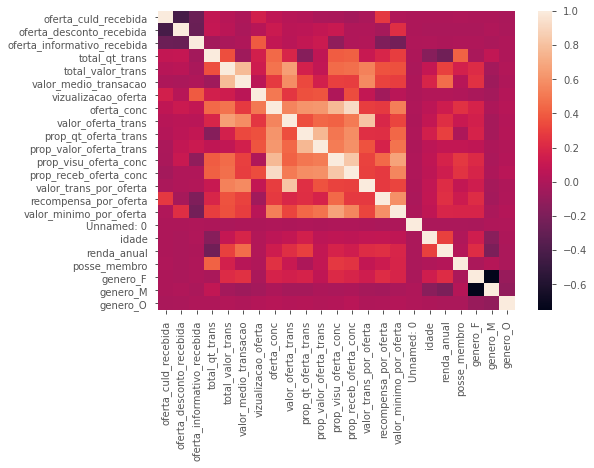

In [204]:
# Vamos visualizar um gráfico da correlação entre cada uma das variáveis
plt.style.use('seaborn-notebook')
sns.heatmap(X.corr())

O desempenho dos modelos é muito bom.

Agora, quais são os recursos mais importantes que distinguem os conversores e não conversores de cada tipo de oferta?

#### Importância dos recursos:

se refere a técnicas que atribuem uma pontuação aos recursos de entrada com base na sua utilidade na previsão de uma variável de destino.

Text(0.5, 1.0, 'importância geral do recurso')

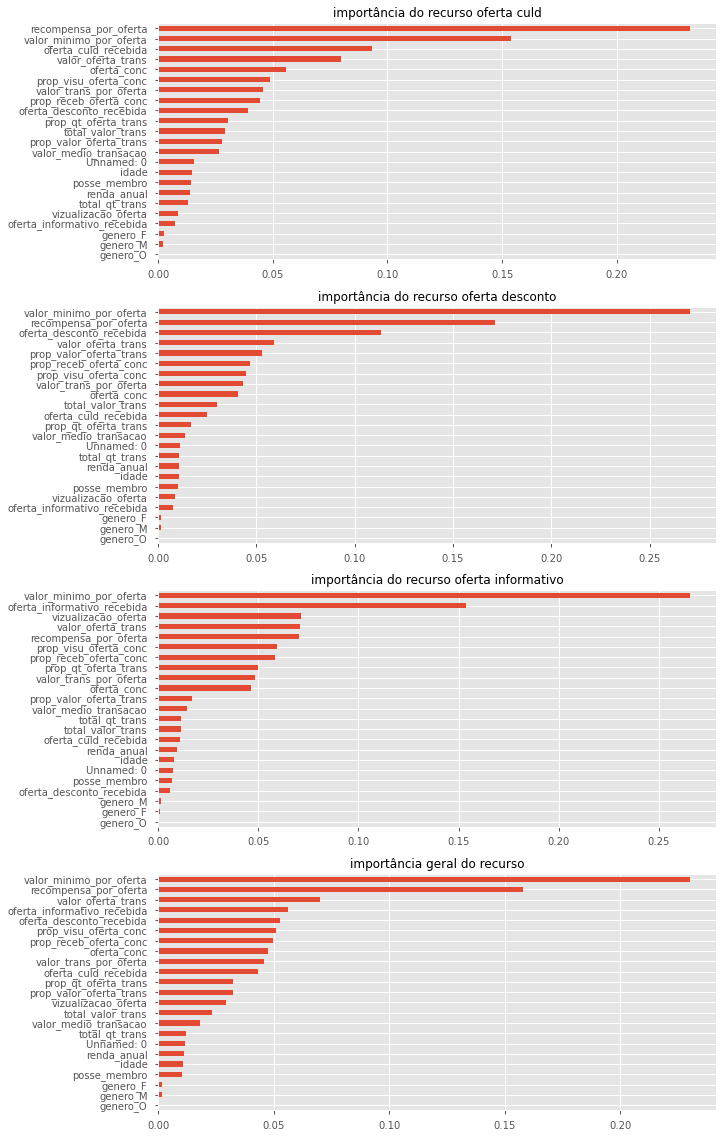

In [205]:
plt.figure(figsize=(10,20))

plt.subplot(4,1,1)
importancia_recurso_rf = pd.Series(clf.estimators_[0].feature_importances_, index = x_train.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância do recurso oferta culd')

plt.subplot(4,1,2)
importancia_recurso_rf = pd.Series(clf.estimators_[1].feature_importances_, index = x_train.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância do recurso oferta desconto')

plt.subplot(4,1,3)
importancia_recurso_rf = pd.Series(clf.estimators_[2].feature_importances_, index = x_train.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância do recurso oferta informativo')

# geral
feat_impts = [] 
for mod in clf.estimators_:
    feat_impts.append(mod.feature_importances_)
    
plt.subplot(4,1,4)
importancia_recurso_rf = pd.Series(np.mean(feat_impts, axis=0), index = x_train.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância geral do recurso')

Parece que 'recompensa_por_oferta', 'valor_minimo_por_oferta' e 'valor_oferta_trans' são os recursos mais importantes em toda a linha. 

Como cada recurso é diferente entre os três tipos de oferta?

#### Diferença de recursos por combinação de oferta

In [206]:
cliente_df_final['valor_trans_sem_oferta'] = cliente_df_final['total_valor_trans']- cliente_df_final['valor_oferta_trans']
cliente_df_final['qt_trans_sem_oferta'] = cliente_df_final['total_qt_trans']- cliente_df_final['oferta_conc']

col_list1 = ['prop_qt_oferta_trans', 'prop_valor_oferta_trans', 'prop_visu_oferta_conc', 
       'prop_receb_oferta_conc']
col_list2 = ['oferta_conc', 'total_qt_trans', 'qt_trans_sem_oferta', 'total_recompensa_recebida', 'recompensa_por_oferta','valor_minimo_por_oferta']
col_list3 = [ 'total_valor_trans',  'valor_oferta_trans',  'valor_trans_por_oferta','valor_medio_transacao', 'valor_trans_sem_oferta']
cliente_df_final[['oferta_culd','oferta_desconto','oferta_informativo']] = \
            cliente_df_final[['oferta_culd','oferta_desconto','oferta_informativo']].astype(int)

In [207]:
def media_por_tipo_oferta (dados, colunas):    
    col = colunas[0]
    df = dados.groupby(['oferta_culd','oferta_desconto','oferta_informativo'])[col].mean().reset_index()
    for col in colunas[1:]:
        curr = dados.groupby(['oferta_culd','oferta_desconto','oferta_informativo'])[col].mean().reset_index()
        df = df.merge(curr, on =['oferta_culd','oferta_desconto','oferta_informativo'])
    return df

Text(0.5, 1.0, 'Média métrica de combinações de tipo de oferta')

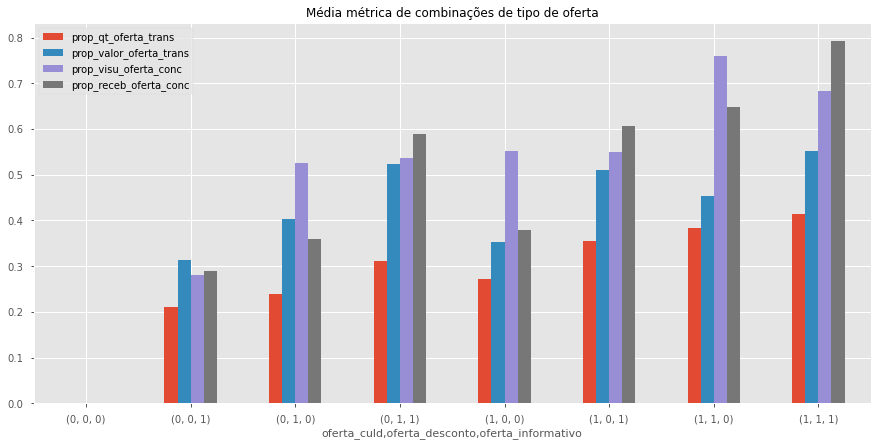

In [208]:
proporcao_df = media_por_tipo_oferta (cliente_df_final, col_list1)

proporcao_df.set_index(['oferta_culd','oferta_desconto','oferta_informativo']).plot.bar(figsize=(15,7), rot = 0)
plt.title('Média métrica de combinações de tipo de oferta')

Text(0.5, 1.0, 'Média métrica de combinações de tipo de oferta')

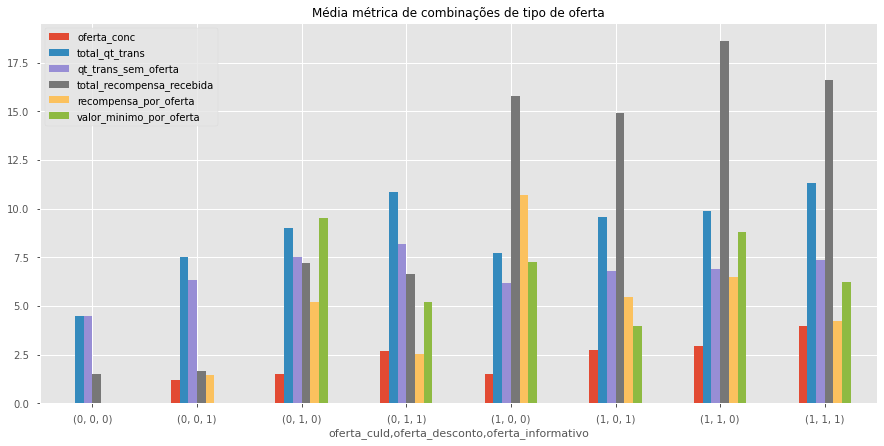

In [209]:
transacoes_df = media_por_tipo_oferta (cliente_df_final, col_list2)

transacoes_df.set_index(['oferta_culd','oferta_desconto','oferta_informativo']).plot.bar(figsize=(15,7), rot = 0)
plt.title('Média métrica de combinações de tipo de oferta')

Text(0.5, 1.0, 'Média métrica de combinações de tipo de oferta')

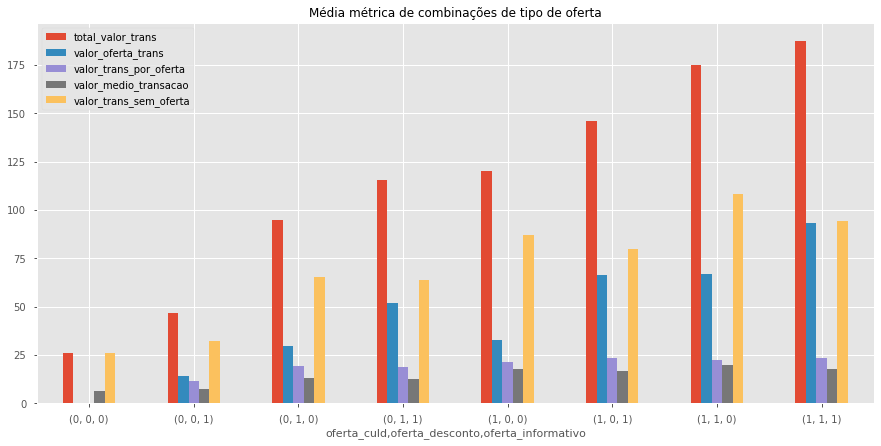

In [210]:
transacoes_df = media_por_tipo_oferta (cliente_df_final, col_list3)

transacoes_df.set_index(['oferta_culd','oferta_desconto','oferta_informativo']).plot.bar(figsize=(15,7), rot = 0)
plt.title('Média métrica de combinações de tipo de oferta')

Os rótulos entre parênteses no eixo x correspondem aos três tipos de ofertas (culd, desconto e informativo, respectivamente). Quando é 1, significa clientes que usam esse tipo de oferta. Então, quando você vê (1,1,0) significa clientes que respondem às ofertas culd e às ofertas de desconto, mas não às ofertas informativas.

Os clientes que que usam os três tipos de oferta não apenas gastam mais com as ofertas, mas também têm o valor total de transação mais alto (barra em vermelho). Isso significa que quanto mais motivarmos os clientes a usar as ofertas, maior é a probabilidade de eles gastarem mais na gelateria.

Além disso, a oferta culd impulsiona mais vendas do que as ofertas de descontos e ofertas de informativos em geral, uma vez que os três grupos com um valor total de transação mais alto responderam todos à oferta culd. Também é interessante notar que os clientes que usam as ofertas culd e as ofertas de desconto (dois últimos no gráfico) gastam praticamente metade do valor total da transação sem ofertas. Esses são os clientes mais ativos e valiosos da gelateria. 

Isso significa que as ofertas com recompensas podem realmente melhorar o envolvimento dos clientes e, como resultado, impulsionar as vendas em geral.

Agora, vamos dar uma olhada em como a taxa geral de conclusão da oferta, a proporção do valor da transação motivada pela oferta e a recompensa por oferta são afetadas pelos dados demográficos do usuário.

#### Usos por dados demográficos

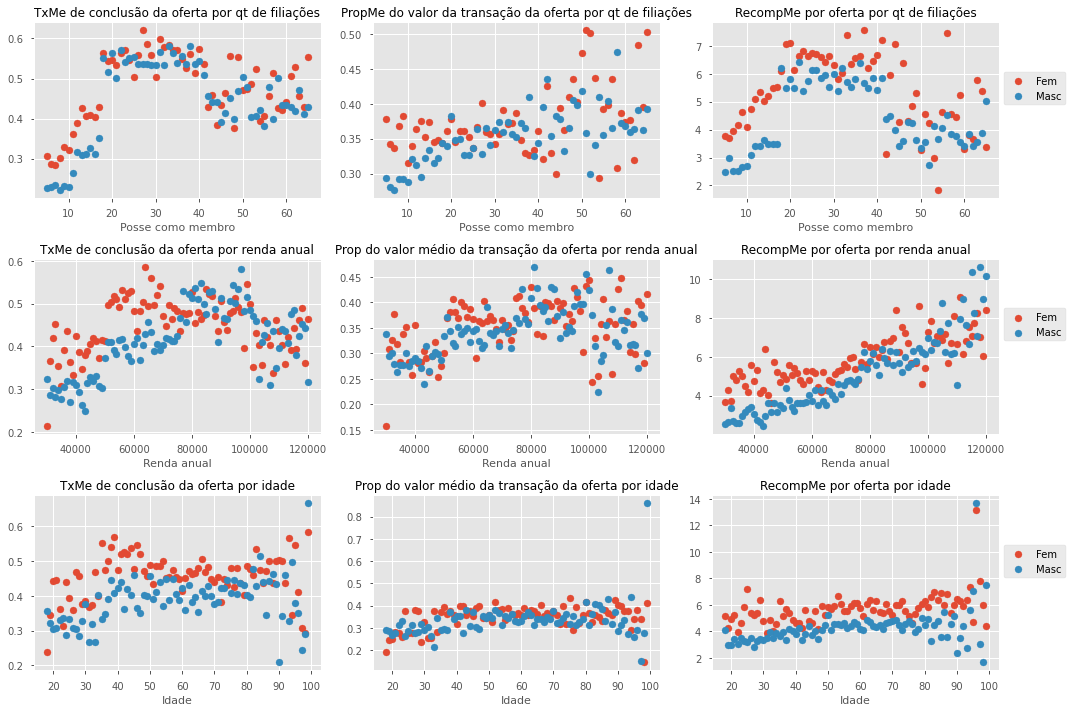

In [211]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('posse_membro').mean()['prop_receb_oferta_conc']
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('posse_membro').mean()['prop_receb_oferta_conc']
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Posse como membro');
plt.title('TxMe de conclusão da oferta por qt de filiações')

plt.subplot(3,3,2)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('posse_membro')['prop_valor_oferta_trans'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('posse_membro')['prop_valor_oferta_trans'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Posse como membro');
plt.title('PropMe do valor da transação da oferta por qt de filiações')


plt.subplot(3,3,3)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('posse_membro')['recompensa_por_oferta'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('posse_membro')['recompensa_por_oferta'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Posse como membro');
plt.title('RecompMe por oferta por qt de filiações')
plt.legend(['Fem', 'Masc'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,4)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('renda_anual').mean()['prop_receb_oferta_conc']
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('renda_anual').mean()['prop_receb_oferta_conc']
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Renda anual');
plt.title('TxMe de conclusão da oferta por renda anual')

plt.subplot(3,3,5)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('renda_anual')['prop_valor_oferta_trans'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('renda_anual')['prop_valor_oferta_trans'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Renda anual');
plt.title('Prop do valor médio da transação da oferta por renda anual')


plt.subplot(3,3,6)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('renda_anual')['recompensa_por_oferta'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('renda_anual')['recompensa_por_oferta'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Renda anual');
plt.title('RecompMe por oferta por renda anual')
plt.legend(['Fem', 'Masc'], bbox_to_anchor=(1.00, 0.5), loc=3);


plt.subplot(3,3,7)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('idade').mean()['prop_receb_oferta_conc']
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('idade').mean()['prop_receb_oferta_conc']
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Idade');
plt.title('TxMe de conclusão da oferta por idade')

plt.subplot(3,3,8)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('idade')['prop_valor_oferta_trans'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('idade')['prop_valor_oferta_trans'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Idade');
plt.title('Prop do valor médio da transação da oferta por idade')


plt.subplot(3,3,9)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('idade')['recompensa_por_oferta'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('idade')['recompensa_por_oferta'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Idade');
plt.title('RecompMe por oferta por idade')
plt.legend(['Fem', 'Masc'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.tight_layout()

Principais conclusões dos gráficos de dispersão acima:

1. A taxa de conclusão da oferta cresce continuamente à medida que a posse aumenta no início, e atinge seu pico quando a permanência do usuário de ambos os sexos está entre 20-30 meses, então diminui um pouco à medida que o tempo de posse aumenta, especialmente para clientes do sexo masculino. Na realidade, a taxa de conversão da oferta aumentaria à medida que os novos clientes se acostumassem com as ofertas e começassem a utilizar os benefícios com mais frequência. Após essa fase, a taxa de conversão estabiliza.


2. A taxa de conclusão da oferta também parece ter uma relação linear positiva com a renda até chegar a 80.000. Depois disso, começa a cair à medida que a renda aumenta. Os clientes estão mais inclinados a usar ofertas quando suas rendas estão abaixo de um determinado nível. Depois de ultrapassar esse nível de renda, o efeito do uso de uma oferta para motivar transações diminui.


3. Em geral, parece não haver uma segmentação significativa de conclusão de ofertas, proporção média do valor da transação ou recompensa média por idade.


4. Em geral, os clientes do sexo feminino têm uma taxa de conclusão da oferta mais alta do que os clientes do sexo masculino, especialmente no período inicial como membros filiados e renda mais baixa.


5. A recompensa média por oferta cresce continuamente à medida que a renda aumenta.


5. As clientes do sexo feminino também tendem a ganhar recompensas mais altas por oferta em quase todo o espectro de filiação,  idade e renda. Isso pode ser porque, em parte, mulheres têm uma taxa de conclusão da oferta mais alta do que os homens. Isso também implica que as usuárias são mais propensas a usar a oferta culd ou ofertas de desconto para ganhar recompensas, uma vez que as ofertas informativas não dão recompensas.

Agora, vamos verificar se grupos demográficos diferentes respondem de maneira diferente aos três tipos de oferta.

#### Tipos de oferta por dados demográficos

In [212]:
import warnings
warnings.filterwarnings("ignore")

#criando novas colunas
cliente_df_final['tx_conv_culd'] = cliente_df_final['culd_concl']/cliente_df_final['oferta_culd_recebida']
cliente_df_final['tx_conv_desconto'] = cliente_df_final['desconto_concl']/cliente_df_final['oferta_desconto_recebida']
cliente_df_final['tx_conv_info'] = cliente_df_final['informativo_concl']/cliente_df_final['oferta_informativo_recebida']

Text(0.5, 1.0, 'Taxa de conversão das ofertas')

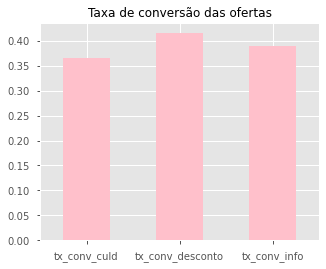

In [213]:
plt.figure(figsize=(5,4))
cliente_df_final[['tx_conv_culd', 'tx_conv_desconto', 'tx_conv_info']].mean().plot.bar(color='pink',rot=0)
plt.title('Taxa de conversão das ofertas', fontsize = 12)


A oferta de desconto tem uma taxa de conversão média ligeiramente mais alta do que os outros dois tipos de oferta, tornando-a a oferta mais eficaz entre três.

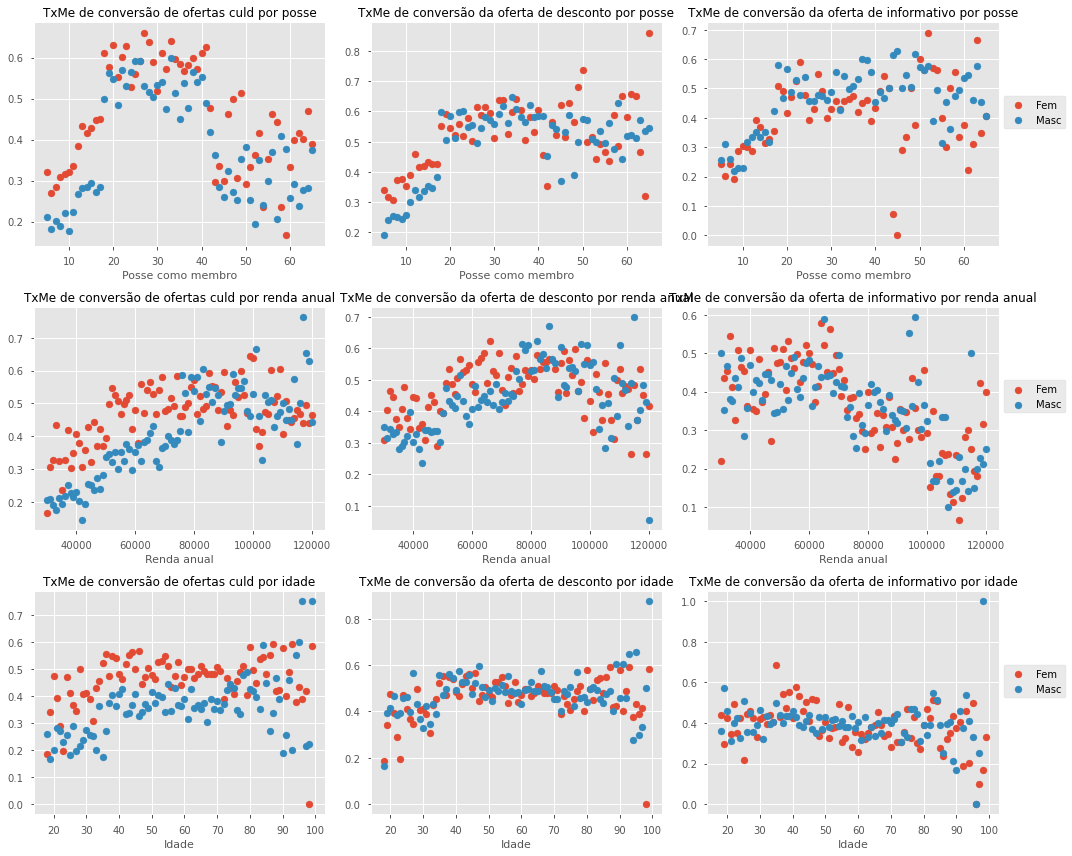

In [214]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(15, 12))

plt.subplot(3,3,1)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('posse_membro')['tx_conv_culd'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('posse_membro')['tx_conv_culd'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Posse como membro');
plt.title('TxMe de conversão de ofertas culd por posse')

plt.subplot(3,3,2)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('posse_membro')['tx_conv_desconto'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('posse_membro')['tx_conv_desconto'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Posse como membro');
plt.title('TxMe de conversão da oferta de desconto por posse')

plt.subplot(3,3,3)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('posse_membro')['tx_conv_info'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('posse_membro')['tx_conv_info'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Posse como membro');
plt.title('TxMe de conversão da oferta de informativo por posse')
plt.legend(['Fem', 'Masc'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,4)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('renda_anual')['tx_conv_culd'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('renda_anual')['tx_conv_culd'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Renda anual');
plt.title('TxMe de conversão de ofertas culd por renda anual')

plt.subplot(3,3,5)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('renda_anual')['tx_conv_desconto'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('renda_anual')['tx_conv_desconto'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Renda anual');
plt.title('TxMe de conversão da oferta de desconto por renda anual')

plt.subplot(3,3,6)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('renda_anual')['tx_conv_info'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('renda_anual')['tx_conv_info'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Renda anual');
plt.title('TxMe de conversão da oferta de informativo por renda anual')
plt.legend(['Fem', 'Masc'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,7)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('idade')['tx_conv_culd'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('idade')['tx_conv_culd'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Idade');
plt.title('TxMe de conversão de ofertas culd por idade')

plt.subplot(3,3,8)
media_masc = cliente_df_final[cliente_df_final.genero_F==1].groupby('idade')['tx_conv_desconto'].mean()
male_avg = cliente_df_final[cliente_df_final.genero_M==1].groupby('idade')['tx_conv_desconto'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Idade');
plt.title('TxMe de conversão da oferta de desconto por idade')

plt.subplot(3,3,9)
media_fem = cliente_df_final[cliente_df_final.genero_F==1].groupby('idade')['tx_conv_info'].mean()
media_masc = cliente_df_final[cliente_df_final.genero_M==1].groupby('idade')['tx_conv_info'].mean()
plt.scatter(media_fem.index, media_fem);
plt.scatter(media_masc.index, media_masc);
plt.xlabel('Idade');
plt.title('TxMe de conversão da oferta de informativo por idade')
plt.legend(['Fem', 'Masc'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.tight_layout()

Existem algumas percepções interessantes desse conjunto de gráficos de dispersão.

1. Tanto a filiação como membro quanto a renda parecem ter um impacto muito grande na taxa de conversão da oferta, enquanto a idade não.


2. Os clientes do sexo feminino mostram uma taxa de conversão cada vez mais alta para a oferta culd em diferentes idades, renda e tempo de filiação, enquanto a oferta informativa tende a ser mais eficaz para os clientes do sexo masculino entre a maioria dos períodos de filiação.


3. A taxa de conversão de ofertas culd por posse como membro mostra um padrão muito semelhante ao da taxa geral de conclusão da oferta - atinge o pico quando as posses dos clientes estão entre 20-30 meses e, em seguida, começa um declínio acentuado. A taxa de conversão da oferta de desconto, por outro lado, mostra um crescimento estável à medida que o tempo como membro aumenta.


4. A taxa de conversão de oferta culd e de desconto crescem à medida que a renda aumenta e, em seguida, apresentam uma ligeira diminuição depois que a renda dos clientes atinge 80.000. No entanto, a taxa de conversão para ofertas de informativos continua diminuindo à medida que a renda aumenta. Esta é uma tendência muito interessante e realmente faz sentido porque ao contrário das ofertas culd e de desconto, as ofertas de informativo não têm um valor mínimo de transação, tornando o valor mínimo para usar a oferta de informações muito menor do que as outras duas ofertas. É por isso que esse tipo de oferta é mais popular entre os grupos de baixa renda. Isso também explica porque as recompensas por oferta no gráfico anterior mostram um aumento consistente à medida que a renda aumenta. As ofertas culd e as ofertas de desconto geralmente são acompanhadas de recompensas e um valor mínimo de transação para usar a oferta, portanto, são mais populares entre o grupo de renda mais alta.

#### Prever o melhor tipo de oferta para qualquer cliente

Se o modelo consegue prever vários tipos de ofertas para determinado cliente, vamos classificar a recomendação com base na probabilidade mais alta de conversão.

In [215]:
y_test_prob = np.array(clf.predict_proba(x_test))
y_test_prob.shape

(3, 3400, 2)

(variáveis de interesse=3, número de clientes no grupo de teste=3400, classes binárias (0/1)=2)

In [216]:
def prever_melhor_oferta (ids_clientes, model):
    '''
    dada uma lista de ids_clientes, vai prever o(s) tipo(s) de oferta a enviar a cada clientex.
    Se houver mais de uma oferta, a saída do tipo de oferta será classificada pela probabilidade prevista em ordem decrescente.
    '''
    tipo_oferta = ['culd','desconto','informativo']
    pred_prob_todos = model.predict_proba(X.loc[ids_clientes])
    pred_class_todos = model.predict(X.loc[ids_clientes])
    
    # reorganizar o array para obter a probabilidade prevista de classe 1 para cada oferta e para cada clientex
    # resultado: número de linhas = número de clientex fornecido, colunas = prob da classe 1 para cada tipo de oferta
    pred_prob_novo = [[pred_prob_todos[c][i][1] for c in range(len(tipo_oferta)) ] for i in range(len(ids_clientes))]

    melhor_oferta = []
    sem_oferta_id =[]
    pred_prob_novo = np.array(pred_prob_novo)
    
    for clientex in range(len(pred_prob_novo)):
        if pred_class_todos[clientex].sum()>0:
            pred_class1_idx = np.argwhere(pred_class_todos[clientex]==1).flatten() # obtenha o índice onde a oferta prevista = 1     
            prob_idx_classificado = np.argsort(-pred_prob_novo[clientex]) # probabilidade de classificação em ordem decrescente
            melhor_idx = [i for i in prob_idx_classificado if i in pred_class1_idx]
            melhor_oferta.append([tipo_oferta[i] for i in melhor_idx])
        else:
            melhor_oferta.append('nenhuma oferta é recomendada para o clientex')
            
    return melhor_oferta

In [80]:
ids_clientes = np.random.choice(x_test.index, 20)
resultado = prever_melhor_oferta (ids_clientes, clf)
for i in range(len(ids_clientes)):
    clientex = ids_clientes[i]
    print('O melhor tipo de oferta para o cliente {} é : {}'.format(clientex, resultado[i]))

O melhor tipo de oferta para o cliente 9a98ee297491498b97ada808e2e7f3c1 é : nenhuma oferta é recomendada para o clientex
O melhor tipo de oferta para o cliente ca24acb9033e47ab9eed2814676d37f2 é : ['culd', 'desconto']
O melhor tipo de oferta para o cliente 6c0df9b1d3b8401c8098c7c7f9977d89 é : ['desconto', 'informativo', 'culd']
O melhor tipo de oferta para o cliente 842080dc78d846858b4a40c3000529cc é : nenhuma oferta é recomendada para o clientex
O melhor tipo de oferta para o cliente a6937b83abe649b38e3c019e559345df é : ['desconto', 'culd']
O melhor tipo de oferta para o cliente ba4fff69b9224b87a1916f9fd9d0c2c8 é : ['culd']
O melhor tipo de oferta para o cliente 95ab36a8edbc4da1b166042d23f6ffa9 é : ['desconto', 'culd']
O melhor tipo de oferta para o cliente 23ac8f87960b45fb90e30a57850b2e4d é : nenhuma oferta é recomendada para o clientex
O melhor tipo de oferta para o cliente cc884499447d4181b59c89efb6e71d84 é : ['desconto', 'culd']
O melhor tipo de oferta para o cliente 3262e55fe1c04

Acima estão os tipos de oferta recomendados para 20 IDs de cliente selecionados aleatoriamente do conjunto de teste. As ofertas de maior probabilidade estão na frente. Se o cliente só tiver transações e nunca tiver usado nenhuma oferta antes, o modelo mostrará "nenhuma oferta é recomendada". No contexto de negócios, se um usuário estiver disposto a gastar 10 reais de qualquer maneira, não precisamos enviar a ele uma oferta de desconto "compre 10 reais e ganhe 2 reais".

#### Prever ofertas específicas para qualquer usuário

Vamos prever não apenas o tipo de oferta, mas também a oferta específica a ser enviada para qualquer cliente. A ideia é que para um cliente que só gosta de utilizar ofertas de valor mínimo, possamos enviar ofertas com base no valor mínimo da oferta e não apenas pelo tipo amplo da oferta, já que o nível de valor mínimo pode variar em um intervalo muito grande para o mesmo tipo de oferta.


Existem 10 ids de oferta na base de portfolio_ofertas: 2 para informativos, 4 para desconto e 4 para culd. Se usarmos a combinação de tipo de oferta + recompensa + valor mínimo para representar cada id de oferta, obtemos 6 nomes de oferta exclusivos: "culd_10_10", "desconto_5_20", "desconto_3_7", "culd_5_5", "desconto_2_10", "informativo_0_0".


Como alguns ids de oferta são mapeados para o mesmo nome de oferta, eles foram consolidados em uma coluna. Se um cliente já fez uma conversão com qualquer um dos ids de oferta no mesmo combo tipo + recompensa + valor mínimo, esse nome de oferta será rotulado como 1, caso contrário 0.


Ainda, vamos substituir os 3 tipos de ofertas pelos 6 nomes de ofertas como Y, nada mudou muito em X, exceto a inclusão de 3 recursos que foram excluídos no último modelo para evitar vazamento de informações: quantidade de ofertas culd, desconto e informativo concluídas. Além disso, vamos criar um novo recurso chamado "valor_minimo_por_oferta" que é a soma da transação mínima de cada oferta concluída dividida pelo número total de ofertas concluídas. 


Esse novo recurso pode dizer muito sobre a tolerância dos clientes quanto ao gasto mínimo para aproveitar os benefícios da oferta.

In [81]:
portfolio_ofertas.head()

,Unnamed: 0,recompensa,canal,valor_minimo,duracao,id_oferta,oferta,web,email,mobile,social
0,1,10,"['email', 'mobile', 'social']",10,7,ae264e3637204a6fb9bb56bc8210ddfd,"compre 1, leve 2",0,1,1,1
1,2,10,"['web', 'email', 'mobile', 'social']",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,"compre 1, leve 2",1,1,1,1
2,3,0,"['web', 'email', 'mobile']",0,4,3f207df678b143eea3cee63160fa8bed,informativo,1,1,1,0
3,4,5,"['web', 'email', 'mobile']",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,"compre 1, leve 2",1,1,1,0
4,5,5,"['web', 'email']",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,desconto,1,1,0,0


In [82]:
# converter o dicionário de id_oferta convertido pelo usuário coletado na etapa de engenharia de recursos
oferta_eficaz_cliente_df = pd.DataFrame(columns = portfolio_ofertas['id_oferta'], index = list(oferta_eficaz_cliente.keys()))
for uid in oferta_eficaz_cliente_df.index:
    for oferta in oferta_eficaz_cliente[uid]:
        oferta_eficaz_cliente_df.loc[uid][oferta] = 1
oferta_eficaz_cliente_df.head()

id_oferta,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN
78afa995795e4d85b5d9ceeca43f5fef,1,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN
e2127556f4f64592b11af22de27a7932,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN
389bc3fa690240e798340f5a15918d5c,NaN,NaN,NaN,1,NaN,NaN,1,NaN,1,1
c4863c7985cf408faee930f111475da3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# combinar as colunas para df principal
cliente_df_final2 = cliente_df_final.join(oferta_eficaz_cliente_df)

# renomeie as colunas offer_id para oferecer nome = tipo de oferta + recompensas + dificuldade
portfolio_ofertas['nome_oferta'] = portfolio_ofertas['oferta'] + '_' + portfolio_ofertas['recompensa'].astype(str) + '_' + portfolio_ofertas['valor_minimo'].astype(str)
cliente_df_final2 = renomear_col(portfolio_ofertas['id_oferta'].values, portfolio_ofertas['nome_oferta'].values, cliente_df_final2)
portfolio_ofertas['nome_oferta'].value_counts()

informativo_0_0           2
desconto_2_10             2
compre 1, leve 2_5_5      2
compre 1, leve 2_10_10    2
desconto_3_7              1
desconto_5_20             1
Name: nome_oferta, dtype: int64

In [84]:
#consolidar várias colunas com o mesmo nome de oferta em uma coluna
cliente_df_final2.fillna(0, inplace = True)
contar_coluna = cliente_df_final2.columns.value_counts()
duplicar_col = contar_coluna[contar_coluna>1].index
for col in duplicar_col:
    col_idx = (np.where(cliente_df_final2.columns== col)[0].tolist())
    novo_nome_col = col + '_novo'
    cliente_df_final2[novo_nome_col] = 0
    for i in col_idx:
        cliente_df_final2[novo_nome_col] = cliente_df_final2[novo_nome_col] + cliente_df_final2.iloc[:, i]
    cliente_df_final2.drop(col, axis=1, inplace=True)
    cliente_df_final2[novo_nome_col] = cliente_df_final2[novo_nome_col].apply(lambda x: 1 if x>=1 else 0 )


In [85]:
cliente_df_final2 = renomear_col(['desconto_2_10_novo', 'informativo_0_0_novo', 'compre 1, leve 2_5_5_novo', 'compre 1, leve 2_10_10_novo'], ['desconto_2_10', 'informativo_0_0', 'compre 1, leve 2_5_5', 'compre 1, leve 2_10_10'], cliente_df_final2)
#cliente_df_final2.fillna(0, inplace=True)
cliente_df_final2.columns

Index(['oferta_culd_recebida', 'oferta_desconto_recebida',
       'oferta_informativo_recebida', 'total_qt_trans', 'total_valor_trans',
       'total_recompensa_recebida', 'valor_medio_transacao',
       'vizualizacao_oferta', 'oferta_conc', 'desconto_concl',
       'valor_oferta_trans', 'valor_minimo_oferta', 'culd_concl',
       'informativo_concl', 'oferta_culd', 'oferta_desconto',
       'oferta_informativo', 'sem_oferta', 'prop_qt_oferta_trans',
       'prop_valor_oferta_trans', 'prop_visu_oferta_conc',
       'prop_receb_oferta_conc', 'valor_trans_por_oferta',
       'recompensa_por_oferta', 'valor_minimo_por_oferta', 'Unnamed: 0',
       'idade', 'renda_anual', 'posse_membro', 'genero_F', 'genero_M',
       'genero_O', 'valor_trans_sem_oferta', 'qt_trans_sem_oferta',
       'tx_conv_culd', 'tx_conv_desconto', 'tx_conv_info', 'desconto_5_20',
       'desconto_3_7', 'compre 1, leve 2_5_5', 'desconto_2_10',
       'compre 1, leve 2_10_10', 'informativo_0_0'],
      dtype='object')

In [86]:
nome_oferta = ['compre 1, leve 2_10_10',  'desconto_5_20', 'desconto_3_7', 'compre 1, leve 2_5_5', 'desconto_2_10', 'informativo_0_0']
del_col = nome_oferta + ['oferta_culd','oferta_desconto','oferta_informativo', 'total_recompensa_recebida','valor_minimo_oferta']

X = cliente_df_final2.drop(del_col, axis=1)
Y = cliente_df_final2[nome_oferta]

x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y, test_size = 0.2)

clf2 = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, oob_score=True))

clf2.fit(x_train2, y_train2)

MultiOutputClassifier(estimator=RandomForestClassifier(oob_score=True))

In [87]:
y_pred2 = clf2.predict(x_test2)
weighted_perform = build_report(y_test2, y_pred2, avg_param = 'weighted')
weighted_perform

,f1 score,precision,recall
"compre 1, leve 2_10_10",0.979780,0.979947,0.979706
desconto_5_20,0.986513,0.987167,0.987059
desconto_3_7,0.970054,0.970122,0.970000
"compre 1, leve 2_5_5",0.978898,0.979057,0.978824
desconto_2_10,0.964124,0.965664,0.963824
informativo_0_0,1.000000,1.000000,1.000000


Com esses novos recursos adicionais, o desempenho do modelo melhorou ainda mais, mudando os tipos de ofertas para ofertas reais como variáveis de destino. 

Para garantir que as pontuações altas não estejam sendo causadas por alta precisão apenas na classe 0, obtivemos os relatórios de classificação para cada modelo de oferta e todos eles parecem bons. (>0.9)

In [88]:
from sklearn.metrics import classification_report
for i in range(len(nome_oferta)):
    print(classification_report(y_test2.values[:, i], y_pred2[:, i]))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2498
           1       0.95      0.97      0.96       902

    accuracy                           0.98      3400
   macro avg       0.97      0.98      0.97      3400
weighted avg       0.98      0.98      0.98      3400

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3148
           1       1.00      0.83      0.90       252

    accuracy                           0.99      3400
   macro avg       0.99      0.91      0.95      3400
weighted avg       0.99      0.99      0.99      3400

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2621
           1       0.93      0.94      0.93       779

    accuracy                           0.97      3400
   macro avg       0.96      0.96      0.96      3400
weighted avg       0.97      0.97      0.97      3400

              preci

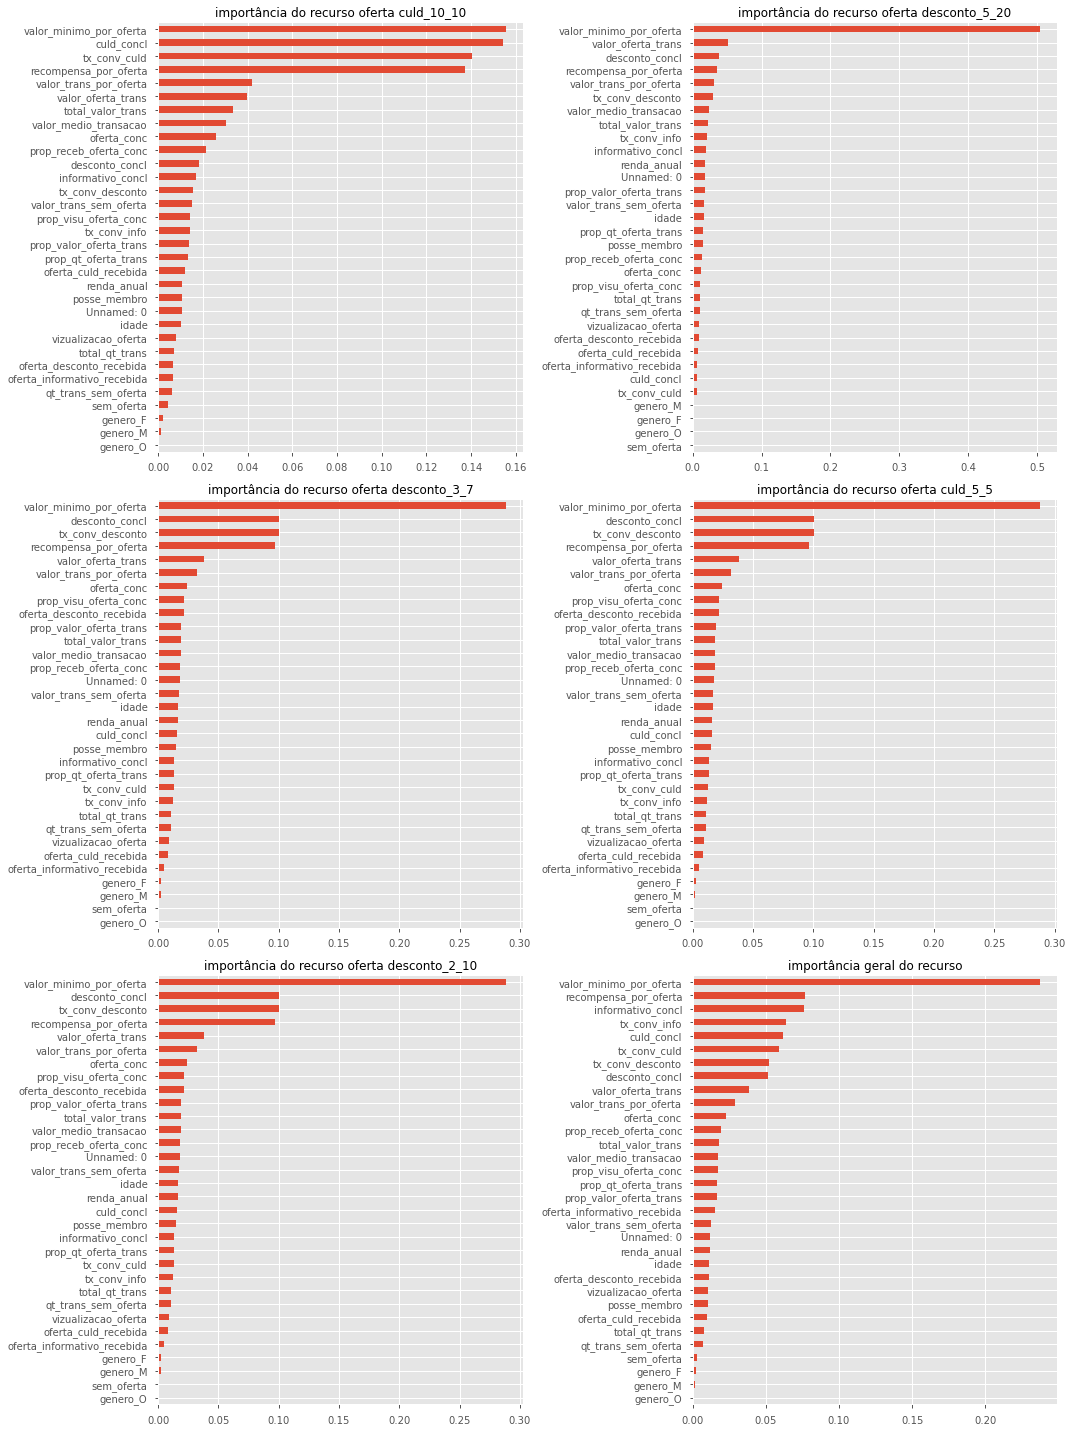

In [89]:
plt.figure(figsize=(15,20))

plt.subplot(3,2,1)
importancia_recurso_rf = pd.Series(clf2.estimators_[0].feature_importances_, index = x_train2.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância do recurso oferta culd_10_10')

plt.subplot(3,2,2)
importancia_recurso_rf = pd.Series(clf2.estimators_[1].feature_importances_, index = x_train2.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância do recurso oferta desconto_5_20')

plt.subplot(3,2,3)
importancia_recurso_rf = pd.Series(clf2.estimators_[2].feature_importances_, index = x_train2.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância do recurso oferta desconto_3_7')

plt.subplot(3,2,4)
importancia_recurso_rf = pd.Series(clf2.estimators_[2].feature_importances_, index = x_train2.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância do recurso oferta culd_5_5')

plt.subplot(3,2,5)
importancia_recurso_rf = pd.Series(clf2.estimators_[2].feature_importances_, index = x_train2.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância do recurso oferta desconto_2_10')

# overall
feat_impts = [] 
for mod in clf2.estimators_:
    feat_impts.append(mod.feature_importances_)
    
plt.subplot(3,2,6)
importancia_recurso_rf = pd.Series(np.mean(feat_impts, axis=0), index = x_train2.columns).sort_values(ascending = True)
importancia_recurso_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('importância geral do recurso')

plt.tight_layout()

valor_minimo_por_oferta é a característica dominante para a maioria dos modelos.

Agora vamos prever a melhor oferta para qualquer cliente

In [90]:
def prever_melhor_oferta (ids_clientes, model, nome_oferta):
    '''
     Dada uma lista de ids_clientes, prever o(s) tipo(s) de oferta a enviar a cada clientex.
     Se houver mais de uma oferta, a saída do tipo de oferta será classificada pela probabilidade prevista em ordem decrescente.
    '''
    
    pred_prob_todos = model.predict_proba(X.loc[ids_clientes])
    pred_class_todos = model.predict(X.loc[ids_clientes])
    
    # reorganize o array para obter a probabilidade prevista de classe 1 para cada oferta para cada clientex
    # resultado: número de linhas = número de clientex fornecido, colunas = prob da classe 1 para cada tipo de oferta  
    
    pred_prob_novo = [[pred_prob_todos[c][i][1] for c in range(len(nome_oferta)) ] for i in range(len(ids_clientes))]

    melhor_oferta = []
    id_sem_oferta =[]
    pred_prob_novo = np.array(pred_prob_novo)
    
    for clientex in range(len(pred_prob_novo)):
        if pred_class_todos[clientex].sum()>0:
            pred_class1_idx = np.argwhere(pred_class_todos[clientex]==1).flatten() # get the index where predicted offer = 1     
            prob_idx_classificado = np.argsort(-pred_prob_novo[clientex]) # sort probability in descending order
            melhor_idx = [i for i in prob_idx_classificado if i in pred_class1_idx]
            melhor_oferta.append([nome_oferta[i] for i in melhor_idx])
        else:
            melhor_oferta.append('nenhuma oferta é recomendada para o clientex')
            
    return melhor_oferta

In [91]:
ids_clientes = np.random.choice(x_test2.index, 20)
resultado = prever_melhor_oferta (ids_clientes, clf2, nome_oferta)
for i in range(len(ids_clientes)):
    clientex = ids_clientes[i]
    print('A melhor oferta para o cliente {} é : {}'.format(clientex, resultado[i]))

A melhor oferta para o cliente ea8ba895b78147a786712e3060d728e1 é : ['compre 1, leve 2_10_10', 'desconto_5_20']
A melhor oferta para o cliente d7f5c33a856240ec8d1186edea08e0fe é : ['compre 1, leve 2_5_5', 'compre 1, leve 2_10_10']
A melhor oferta para o cliente 1e211df9e98f4147a9626ab9d2da45a4 é : ['compre 1, leve 2_5_5', 'desconto_3_7', 'desconto_2_10']
A melhor oferta para o cliente 5bbadf84eabe4fa3a7da35e3f44f8a2c é : ['compre 1, leve 2_10_10']
A melhor oferta para o cliente ecb591a8efae462c9f24f5a36aa4a541 é : ['informativo_0_0']
A melhor oferta para o cliente 8be58f600459402b9ec6f2c80bd7d364 é : ['compre 1, leve 2_10_10']
A melhor oferta para o cliente cb351d3c1d3647a8bb6da47ae25d33c0 é : ['informativo_0_0', 'desconto_2_10']
A melhor oferta para o cliente 3cc18472ed634128b409baa2a48700f4 é : ['desconto_5_20', 'desconto_2_10', 'compre 1, leve 2_5_5']
A melhor oferta para o cliente ac994f56c4c7421d965105a11bf10795 é : nenhuma oferta é recomendada para o clientex
A melhor oferta para

Acima estão as ofertas recomendadas para usuários selecionados aleatoriamente do conjunto de teste usando a mesma função de previsão usada anteriormente.

In [92]:
# validar um cliente: oferta prevista x verdade básica
cliente_df_final2.loc['37d27dc053ea481a94009b7e5ec92308', ['compre 1, leve 2_10_10',  'desconto_5_20', 'desconto_3_7', 'compre 1, leve 2_5_5', 'desconto_2_10', 'informativo_0_0']]
# culd_10_10 é uma oferta adicional que o usuário não usou, mas recomendada pelo modelo

compre 1, leve 2_10_10    0.0
desconto_5_20             1.0
desconto_3_7              1.0
compre 1, leve 2_5_5      1.0
desconto_2_10             0.0
informativo_0_0           0.0
Name: 37d27dc053ea481a94009b7e5ec92308, dtype: float64

In [93]:
cliente_df_final2.loc['8342730171dc4deb8e6ee3804fa34b5b', ['compre 1, leve 2_10_10',  'desconto_5_20', 'desconto_3_7', 'compre 1, leve 2_5_5', 'desconto_2_10', 'informativo_0_0']]
# este usuário nunca converteu uma oferta em compra, então o modelo não tem nada a recomendar

compre 1, leve 2_10_10    0.0
desconto_5_20             0.0
desconto_3_7              0.0
compre 1, leve 2_5_5      0.0
desconto_2_10             0.0
informativo_0_0           0.0
Name: 8342730171dc4deb8e6ee3804fa34b5b, dtype: float64

### 4. Clusterização/Segmentação

Até aqui fizemos uma análise para saber qual é o melhor tipo de oferta para enviar a cada cliente especificamente. 

A partir disso, podemos buscar agora um padrão geral de características comportamentais e demográficas para determinados subgrupos de clientes que os diferenciam uns dos outros. 

Isso nos permitirá entender o comportamento dos clientes não só no nível individual, mas também em um contexto de segmentação de mercado. Isso é muito bom e importante porque nos possibilita traçar diferentes estratégias de marketing para os diferentes subgrupos. Esse é o verdadeiro "target marketing".

Vamos lá! 

In [117]:
# pra começar, vamos preencher com 0 os NAs da base com a qual iremos trabalhar
cliente_df_final.fillna(0, inplace=True)
# Visualizando a base final que iremos trabalhar 
cliente_df_final.head()

,oferta_culd_recebida,oferta_desconto_recebida,oferta_informativo_recebida,total_qt_trans,total_valor_trans,total_recompensa_recebida,valor_medio_transacao,vizualizacao_oferta,oferta_conc,desconto_concl,...,renda_anual,posse_membro,genero_F,genero_M,genero_O,valor_trans_sem_oferta,qt_trans_sem_oferta,tx_conv_culd,tx_conv_desconto,tx_conv_info
id,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0.0,5.0,0.0,9.0,20.40,5.0,2.27,5.0,2.0,2.0,...,64000.0,23.0,0,0,0,2.69,7.0,0.000000,0.4,0.0
0610b486422d4921ae7d2bf64640c50b,1.0,0.0,1.0,3.0,77.01,5.0,25.67,0.0,0.0,0.0,...,112000.0,18.0,1,0,0,77.01,3.0,0.000000,0.0,0.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,0.0,1.0,6.0,14.30,0.0,2.38,1.0,0.0,0.0,...,64000.0,6.0,0,0,0,14.30,6.0,0.000000,0.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,0.0,1.0,7.0,159.27,20.0,22.75,5.0,3.0,0.0,...,100000.0,20.0,1,0,0,68.27,4.0,0.666667,0.0,1.0
a03223e636434f42ac4c3df47e8bac43,0.0,3.0,2.0,3.0,4.65,0.0,1.55,5.0,0.0,0.0,...,64000.0,17.0,0,0,0,4.65,3.0,0.000000,0.0,0.0


In [118]:
# para ficar mais fácil copiar os nomes nas colunas que iremos trabalhar, faça:
cliente_df_final.columns

Index(['oferta_culd_recebida', 'oferta_desconto_recebida',
       'oferta_informativo_recebida', 'total_qt_trans', 'total_valor_trans',
       'total_recompensa_recebida', 'valor_medio_transacao',
       'vizualizacao_oferta', 'oferta_conc', 'desconto_concl',
       'valor_oferta_trans', 'valor_minimo_oferta', 'culd_concl',
       'informativo_concl', 'oferta_culd', 'oferta_desconto',
       'oferta_informativo', 'sem_oferta', 'prop_qt_oferta_trans',
       'prop_valor_oferta_trans', 'prop_visu_oferta_conc',
       'prop_receb_oferta_conc', 'valor_trans_por_oferta',
       'recompensa_por_oferta', 'valor_minimo_por_oferta', 'Unnamed: 0',
       'idade', 'renda_anual', 'posse_membro', 'genero_F', 'genero_M',
       'genero_O', 'valor_trans_sem_oferta', 'qt_trans_sem_oferta',
       'tx_conv_culd', 'tx_conv_desconto', 'tx_conv_info'],
      dtype='object')

O modelo que vamos utilizar para a clusterização é o K-means. Esse modelo nos permite trabalhar com aprendizado não supervisionado, ou seja, não necessita de inputs de confirmação externos. Esse aprendizado avalia e segmenta os dados de acordo com suas características. Isso é exatamente o que queremos! 

para entender rapidamente sobre o modelo k-means, por favor, acesse:

https://medium.com/programadores-ajudando-programadores/k-means-o-que-%C3%A9-como-funciona-aplica%C3%A7%C3%B5es-e-exemplo-em-python-6021df6e2572

Vamos utilizar o 'método de cotovelo' para descobrir o melhor número de clusters (ou segmentos)

para entender rapidamente sobre clusterização utilizando o k-means e a curva de cotovelo (do inglês Elbow Method), por favor, acesse:

https://www.kaggle.com/eriveltonguedes/7-clusteriza-o-k-means-erivelton

https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9


Text(0.5, 1.0, 'Melhor número de clusters')

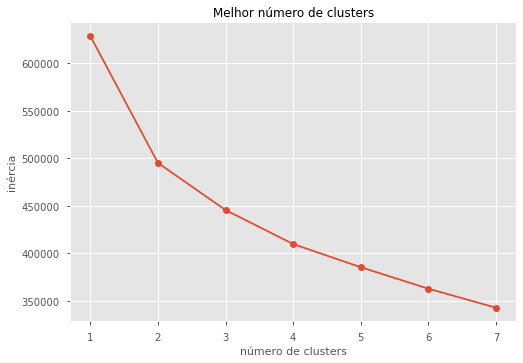

In [123]:
# Vamos ajustar o modelo k-means em características de clientes padronizadas com vários números de clusters e extrair a inércia em cada iteração.

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
padrao = StandardScaler()
cliente_df_padrao = padrao.fit_transform(cliente_df_final)

n_clusters = range(1,8)
inercias = []
for k in n_clusters:
    model = KMeans(n_clusters = k)
    model.fit(cliente_df_padrao)
    inercias.append(model.inertia_)
    
plt.plot(n_clusters, inercias, '-o')
plt.xlabel('número de clusters')
plt.ylabel('inércia')
plt.title('Melhor número de clusters')

O que geralmente acontece ao aumentar a quantidade de clusters no k-means é que as diferenças entre clusters se tornam muito pequenas, e as diferenças das observações intra-clusters vão aumentando. Então é preciso achar um equilíbrio em que as observações que formam cada agrupamento sejam o mais homogêneas possível e que os agrupamentos formados sejam o mais diferentes um dos outros.

Cada ponto vermelho é uma quantidade de clusters, note que começamos em 1 e vamos até 7 clusters. 

Vamos utilizar 3 clusters e ajustar o modelo novamente com n_clusters = 3 e transformar inversamente os dados de volta à escala original.

In [ ]:
# para denifir o número ótimo de cluster
def numero_otimo_cluster(wcss):
    x1, y1 = 1, wcss[0]
    x2, y2 = 7, wcss[len(wcss)-1]

    distancias = []
    for i in range(len(wcss)):
        x0 = i+1
        y0 = wcss[i]
        numerador = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominador = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distancias.append(numerador/denominador)
    
    return distancias.index(max(distancias)) + 1

In [128]:
km2 = KMeans(n_clusters = 3)
km2.fit(cliente_df_padrao)
atribuicao_cluster = pd.DataFrame(padrao.inverse_transform(cliente_df_padrao), columns = cliente_df_final.columns)
atribuicao_cluster['rotulo_cluster'] = km2.labels_ 
cluster_center = pd.DataFrame(km2.cluster_centers_, columns = cliente_df_final.columns)

In [129]:
atribuicao_cluster['rotulo_cluster'].value_counts()

1    7909
0    5083
2    4008
Name: rotulo_cluster, dtype: int64

Abaixo estão os centros de cluster de cada atributo para os 3 clusters.

In [130]:
cluster_center_inv = pd.DataFrame(padrao.inverse_transform(cluster_center), columns = cliente_df_final.columns)

In [131]:
cluster_center_inv[['prop_qt_oferta_trans', 'prop_valor_oferta_trans', 'prop_visu_oferta_conc',
       'prop_receb_oferta_conc', 'valor_trans_por_oferta', 'recompensa_por_oferta',
       'idade', 'renda_anual', 'posse_membro', 'genero_F', 'genero_M', 'genero_O',
       'valor_trans_sem_oferta', 'qt_trans_sem_oferta', 'tx_conv_culd', 'tx_conv_desconto', 'tx_conv_info']]

,prop_qt_oferta_trans,prop_valor_oferta_trans,prop_visu_oferta_conc,prop_receb_oferta_conc,valor_trans_por_oferta,recompensa_por_oferta,idade,renda_anual,posse_membro,genero_F,genero_M,genero_O,valor_trans_sem_oferta,qt_trans_sem_oferta,tx_conv_culd,tx_conv_desconto,tx_conv_info
0,0.038190,0.054930,0.053709,0.049833,1.326777,0.235688,52.814283,59607.711981,16.788117,0.211883,0.505213,0.008460,24.607761,4.796577,0.005322,0.000820,1.449275e-01
1,0.304709,0.411006,0.625822,0.478592,21.131677,7.135338,55.525604,68942.091288,23.932356,0.433051,0.491971,0.014035,88.716528,6.973701,0.454333,0.525671,2.442491e-15
2,0.354127,0.523605,0.571431,0.645247,22.196347,3.910559,54.299401,65014.970060,25.604291,0.405938,0.505240,0.014471,77.883545,7.430639,0.459685,0.507676,8.427021e-01


In [404]:
cluster_center_inv[['oferta_culd_recebida', 'oferta_desconto_recebida', 'oferta_informativo_recebida', 
                     'total_qt_trans', 'total_valor_trans','total_recompensa_recebida', 'valor_medio_transacao',
                     'vizualizacao_oferta', 'oferta_conc', 'desconto_concl', 'valor_oferta_trans', 'culd_concl',
                     'informativo_concl', 'oferta_culd', 'oferta_desconto', 'oferta_informativo', 'sem_oferta']]



,oferta_culd_recebida,oferta_desconto_recebida,oferta_informativo_recebida,total_qt_trans,total_valor_trans,total_recompensa_recebida,valor_medio_transacao,vizualizacao_oferta,oferta_conc,desconto_concl,valor_oferta_trans,culd_concl,informativo_concl,oferta_culd,oferta_desconto,oferta_informativo,sem_oferta
0,1.765493,1.607122,0.923667,5.004328,25.934539,1.436750,5.688251,3.346646,0.207751,0.002164,1.326777,0.014165,1.914224e-01,0.014165,0.002164,1.914224e-01,7.922487e-01
1,1.563124,1.606786,1.614022,10.467315,146.147058,11.833084,15.670167,5.400948,3.036677,0.942116,68.263513,0.850798,1.243762e+00,0.590070,0.654940,9.997505e-01,3.885781e-16
2,1.929447,2.014667,0.514730,9.048299,133.755127,13.901378,17.078208,3.565685,2.074599,1.113921,45.038599,0.960678,1.165734e-15,0.640915,0.749905,5.107026e-15,3.793147e-04


A partir dos centros de clusters, podemos obervar alguns pontos:

1. A idade média é quase a mesma nos três clusters (52, 54 e 55). Talvez não haja praticamente nenhuma segmentação por idade porque a gente transformou os outliers de idade na média e isso pode ter puxado muito pra média no geral. Daria para refazer a análise utilizando a mediana e analisar se existe uma diferença significativa na segmentação.


2. O cluster 0 tem muito mais clientes do sexo masculino do que feminino, menor renda média, valor da transação e taxa de conclusão de ofertas. Podemos pensar que são clientes inativos, que compram de vez em quando.


3. Os clusters 1 e 2 são muito semelhantes na posse média de membros, valor total da transação e valor da transação por oferta. No entanto, eles claramente mostram diferentes padrões de preferência para diferentes tipos de oferta. Vamos confirmar isso com algumas visualizações.

#### Visualização dos Clusters 

<AxesSubplot:xlabel='renda_anual', ylabel='total_valor_trans'>

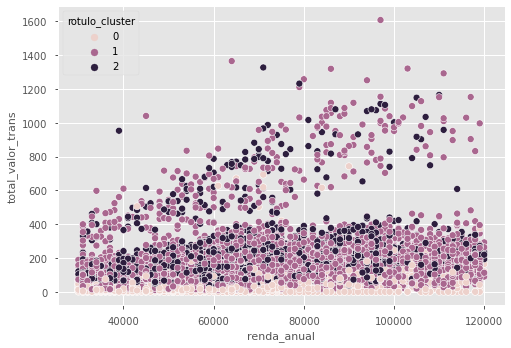

In [132]:
sns.scatterplot(atribuicao_cluster['renda_anual'], atribuicao_cluster['total_valor_trans'], hue= atribuicao_cluster['rotulo_cluster'])

Os clusters 1 e 2 têm algumas pessoas com gastos extremamente altos e alta renda anual.

Vamos plotar um 'boxplot', que representa a função densidade de probabilidade estimada via kernel. A vantagem de se utilizar ele ao invés de uma tabela descritiva (com média, desvio padrão, mediana, etc…), é que é possível visualizar a distribuição dos dados rapidamente, sem precisar olhar especificamente para cada dado do seu conjunto de dados, que é uma tarefa inviável.

para entender rapidamente, por favor, acesse: https://gpestatistica.netlify.app/blog/boxplot/

<AxesSubplot:xlabel='oferta_conc', ylabel='total_valor_trans'>

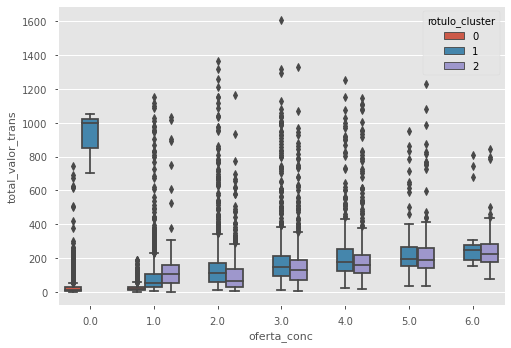

In [137]:
sns.boxplot(atribuicao_cluster['oferta_conc'], atribuicao_cluster['total_valor_trans'], hue= atribuicao_cluster['rotulo_cluster'])

<AxesSubplot:xlabel='prop_receb_oferta_conc', ylabel='valor_trans_sem_oferta'>

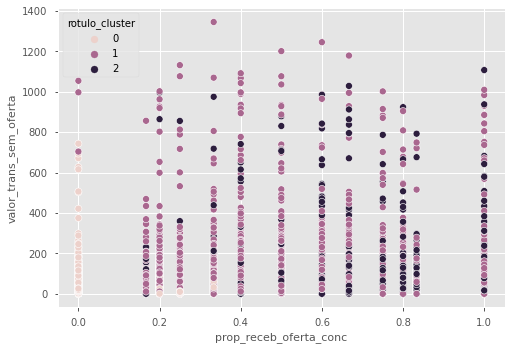

In [134]:
sns.scatterplot(atribuicao_cluster['prop_receb_oferta_conc'], atribuicao_cluster['valor_trans_sem_oferta'][atribuicao_cluster['valor_trans_sem_oferta']>=0], \
                hue= atribuicao_cluster['rotulo_cluster'])

O cluster 0 geralmente não responde às ofertas. o cluster 2 parece ter a taxa de conclusão de oferta mais alta em média, enquanto o cluster 1 gasta mais sem oferta do que o cluster 2.

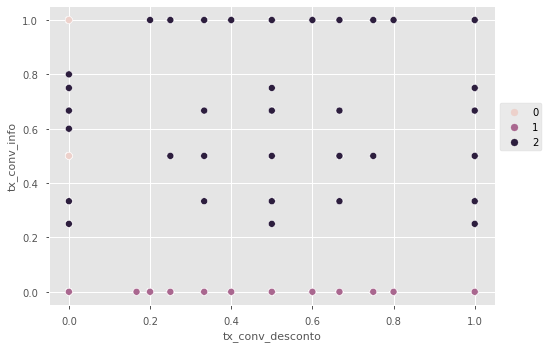

In [135]:
sns.scatterplot(atribuicao_cluster['tx_conv_desconto'], atribuicao_cluster['tx_conv_info'], hue= atribuicao_cluster['rotulo_cluster'])
plt.legend(bbox_to_anchor=(1.00, 0.5), loc=3);

o cluster 1 não tem taxa de conversão de oferta informacional, enquanto no cluster 2 pessoas aparentemente preferem as ofertas informacionais entre os 3 grupos.

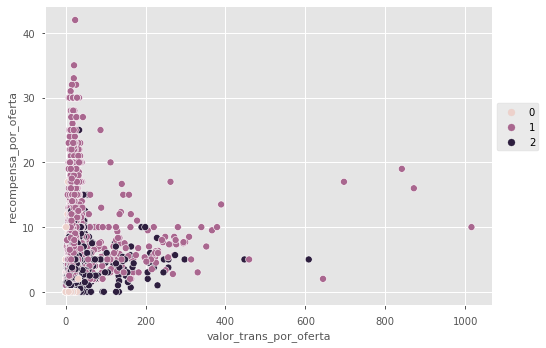

In [136]:
sns.scatterplot(atribuicao_cluster['valor_trans_por_oferta'], atribuicao_cluster['recompensa_por_oferta'], hue= atribuicao_cluster['rotulo_cluster'])
plt.legend(bbox_to_anchor=(1.00, 0.5), loc=3);

O Cluster 1 claramente tem recompensas muito mais altas por oferta em média, o que significa que eles estão mais inclinados a usar ofertas com recompensas mais altas e o mínimo de transação mais alto que vem acompanhado.

#### Descrições dos Clusters/Segmentos

A partir das visualizações acima, juntamente com os centros de cluster, podemos ver que cada cluster tem um conjunto de características distintas em seus comportamentos transacionais e diferentes reações às diferentes ofertas, embora compartilhem dados demográficos muito semelhantes em algumas características, como idade, renda anual e possse como membros.

1. Cluster 0: esse grupo é formado majoritariamente clientes do sexo masculino com idade média de 52 anos (são os mais novos em comparação com a idade média dos outros grupos). É composto principalmente de contas inativas, em geral são compradores pouco frequentes e não respondem às ofertas, também transacionam muito menos do que os outros dois grupos. Na verdade, muitos deles neste grupo são rotulados como clientes "sem oferta". Eles procuram a gelateria de vez em quando, mas definitivamente não são a principal base de clientes. Isso se alinha com o que encontramos no gráfico de taxa de conversão de ofertas por gênero.


2. Cluster 1: esse grupo é formado em sua maioria por clientes do sexo masculino com idade mé dia de 55 anos. É um grupo altamente motivado por ofertas de recompensas do tipo culd e desconto; e quase nunca responde a ofertas informativas. Eles têm a renda média mais alta e têm um valor total de transações também mais alto, porém semelhante ao grupo do cluster 2. Possuem também a maior taxa de conclusão de oferta e gastam mais sem oferta do que com oferta. São clientes muito ativos da gelateria e que gastam mais, em média, e as ofertas mais eficazes para eles são ofertas de descontos e ofertas culd.


3. Cluster 2: esse grupo também é formado em maioria por clientes do sexo masculino com idade média de 54 anos. Essa segmentação também forma um grupo ativo da gelateria, em que os clientes também possuem uma taxa de conclusão de oferta alta no geral. A maior diferença entre o cluster 2 e o cluster 1 é que o grupo 2 tem uma taxa de conversão de oferta informativa muito alta, embora as taxas de conversão de oferta de desconto e culd sejam bem similares ao grupo do cluster 1. Isso significa que este grupo de clientes está mais propenso a usar ofertas sem restrições mínimas de transação e podemos priorizar o envio de ofertas com valor mínimo mais baixo que eles provavelmente usarão. Portanto, o tipo de oferta a enviar para esse segmento é informativo > desconto > culd.